<a href="https://colab.research.google.com/github/alruizzo/missing_persons/blob/main/Missing_older_adults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the probability of finding missing older adults based on machine learning**
---



## **1 Import packages**
---

In [ ]:
# Install Pycaret
!pip install pycaret &> /dev/null

# Data handling
import pandas as pd             
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve
from yellowbrick.classifier import ClassificationReport

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from datetime import datetime

# ML models
from pycaret.classification import *
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
!pip install shap &> /dev/null
import shap

## **2 Load data**
---


In [ ]:
datos = pd.read_csv("https://drive.google.com/uc?id=1GsZMWNCCHtEgZv5cHphnytM971iZxXZG")
datos

,ID,Estado de la desaparición,Clasificación de la desaparición,Fecha de la desaparición,Edad al momento de la desaparición,Sexo del desaparecido,País de nacimiento del desaparecido,Ancestro racial del desaparecido,Estado civil del desaparecido,Escolaridad del desaparecido,Factor de vulnerabilidad del desaparecido,País donde ocurre la desaparición,Municipio donde ocurre la desaparición DANE,Departamento donde ocurre la desaparición DANE,Contexto
0,1,Desaparecido,Sin Información,2006-12-29T00:00:00.000,21,Hombre,Sin información,Mestizo,Soltero (a),Educación básica secundaria o secundaria baja,Persona adicta a una droga natural o sintética,Sin información,Sin información,Sin información,Desaparición
1,2,Desaparecido,Sin Información,2006-12-26T00:00:00.000,24,Hombre,Colombia,Mestizo,Soltero (a),Educación básica secundaria o secundaria baja,Persona adicta a una droga natural o sintética,Colombia,"Bogotá, D.C.","Bogotá, D.C.",Desaparición
2,3,Desaparecido,Sin Información,2006-12-29T00:00:00.000,13,Mujer,Colombia,Mestizo,Soltero (a),Educación básica secundaria o secundaria baja,Ninguno,Colombia,"Bogotá, D.C.","Bogotá, D.C.",Desaparición
3,4,Aparecio Muerto,Sin Información,2006-12-31T00:00:00.000,50,Hombre,Colombia,Blanco,Soltero (a),Educación básica primaria,Persona adicta a una droga natural o sintética,Sin información,Sin información,Sin información,Desaparición
4,5,Aparecio Vivo,Sin Información,2006-12-29T00:00:00.000,17,Mujer,Sin información,Mestizo,Soltero (a),Educación técnica profesional y tecnológica,Ninguno,Colombia,"Bogotá, D.C.","Bogotá, D.C.",Desaparición
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162396,162397,Aparecio Vivo,Sin Información,2021-06-22T00:00:00.000,36,Hombre,Venezuela,Mestizo,Soltero (a),Educación media o secundaria alta,Ninguno,Colombia,"Bogotá, D.C.","Bogotá, D.C.",Desaparición
162397,162398,Desaparecido,Desaparición Presuntamente Forzada,2021-06-27T00:00:00.000,17,Hombre,Colombia,Mestizo,Soltero (a),Educación básica primaria,Ninguno,Colombia,Quibdó,Chocó,Desaparición
162398,162399,Desaparecido,Sin Información,2000-03-15T00:00:00.000,29,Hombre,Colombia,Mestizo,Soltero (a),Sin información,Campesinos (as) y/o trabajadores (as) del campo,Colombia,Tibú,Norte de Santander,Desaparición
162399,162400,Desaparecido,Sin Información,2021-06-29T00:00:00.000,33,Hombre,Colombia,Sin Información,Soltero (a),Educación media o secundaria alta,Ninguno,Colombia,Cúcuta,Norte de Santander,Desaparición


## **3 Check data**
---

In [ ]:
# Data info
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582 entries, 34 to 162382
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6582 non-null   category
 1   status          6582 non-null   category
 2   edad            6582 non-null   int64   
 3   sexo            6582 non-null   category
 4   escolaridad     5078 non-null   float64 
 5   vulnerabilidad  5566 non-null   category
 6   municipio       6560 non-null   float64 
 7   dias            6582 non-null   int64   
 8   año             6582 non-null   int64   
 9   relacion        6065 non-null   category
 10  aparecio        6582 non-null   category
dtypes: category(6), float64(2), int64(3)
memory usage: 673.5 KB


In [ ]:
# List variables for variable name adjustment
datos.columns

Index(['ID', 'status', 'edad', 'sexo', 'escolaridad', 'vulnerabilidad',
       'municipio', 'dias', 'año', 'relacion', 'aparecio'],
      dtype='object')

In [ ]:
# Simplify (and change) variable names
datos.columns = ['ID', 'status', 'clasificacion',
       'fecha', 'edad', 'sexo', 'pais_nac', 'ancestro', 'estado_civil',
       'escolaridad', 'vulnerabilidad', 'pais_desap',
       'munic_desap_DANE', 'dept_desap_DANE', 'contexto']
datos.columns

Index(['ID', 'status', 'clasificacion', 'fecha', 'edad', 'sexo', 'pais_nac',
       'ancestro', 'estado_civil', 'escolaridad', 'vulnerabilidad',
       'pais_desap', 'munic_desap_DANE', 'dept_desap_DANE', 'contexto'],
      dtype='object')

## **4 Delete examples without information in the most relevant variables**
---

### **a. Age**
*Age is important because we expect lower probability of being found for those cases with more advanced age*

In [ ]:
# Check unique values to have a sense of the necessary adjustments
datos.edad.unique()

array(['21', '24', '13', '50', '17', '41', '71', '25', '20', '35', '15',
       '54', '40', '29', '28', '14', '55', '19', '27', '39', '47', '45',
       '36', '87', '44', '43', '56', '11', '31', '22', '63', '48', '18',
       '16', '38', '58', '70', '23', '33', '30', '62', '42', '100', '52',
       '12', '72', '74', '7', '26', '9', '32', '46', '34', '51', '8',
       '53', '79', '76', '49', '5', '57', '10', '60', '65', '78', '69',
       '84', '83', '6', '64', '73', '82', '59', '68', '67', '66', '80',
       '37', '75', '77', '88', '1.083', '86', '2', '85', '0.083', '94',
       '4', '1.25', '0.583', '0.333', '81', '89', '3', '0.666', '61',
       '0.166', '0.25', '1.5', '0.916', 'Sin información', '0.416', '1',
       '91', '0.5', '90', '95', '99', '101', '0', '103', '1.666', '96',
       '93', '98', '92', '97', '0.833', '0.75', '1.583', '104', '1.333',
       '1.833', '1.416', '1.75', '1.916', '1.166', '110', '2.75', '112',
       '102', '2.083', '107', '2.916', '108', '3.333', '4.33

In [ ]:
# Select examples with null values in the variable Age (determine how many
# missing values there are)
InfoEdad = datos["edad"] != 'Sin información'
len(datos[InfoEdad])                          # n = 202 have no age information

162199

### **b. Date of missingness**
*Date is relevant because we expect a lower probability of being found for someone with a missigness occurred a longer time ago.*

In [ ]:
# Check unique values of date to have a sense of possible adjustments to make
datos.fecha.unique()

array(['2006-12-29T00:00:00.000', '2006-12-26T00:00:00.000',
       '2006-12-31T00:00:00.000', ..., '2021-06-28T00:00:00.000',
       '2021-06-29T00:00:00.000', '2021-06-30T00:00:00.000'], dtype=object)

In [ ]:
# Select examples with null values (determine how many are missing)
InfoFecha = datos["fecha"] != 'Sin información'
len(datos[InfoFecha])                         # n = 129 have no info on the year

162272

### **c. Classification of missingness**
*Classification of missingness is relevant because if the missingness is allegedly forced (i.e., forced disappearance), then this case is beyond the intrinsic and extrinsic factors that we think could influence the probability of being found.*

In [ ]:
# Select those examples that do not correspond to allegedly forced disappearance
InfoClasif = datos.clasificacion != 'Desaparición Presuntamente Forzada' 
len(datos[InfoClasif])                       # n = 32403 have classification
                                             # allegedly forced disappearance

129998

In [ ]:
# Check unique values of classification of missingness
datos.clasificacion.unique()

array(['Sin Información', 'Desaparición Presuntamente Forzada'],
      dtype=object)

### **Filtering out**

- Delete null values in the most important variables (age and date of missingness) as well as those with classification of missingness as allegedly forced.

In [ ]:
# So far we can filter out those selected previously
datos = datos[InfoEdad & InfoFecha & InfoClasif]
len(datos)                                      # n = 129,776

129776

- Delete redundant variables, i.e., those that won't be needed in the model

In [ ]:
# Delete variables that are not needed or are redundant
datos.drop(['contexto',         # redundant with "classification"
            'clasificacion',    # only has one class
            'pais_nac',         # not deemed relevant
            'ancestro'],        # not deemed relevant
           1, inplace = True)

- Leave in only relevant examples: older adults with age >= 60 years at the time of missingness and cases with status "Still missing" or "Found alive".

In [ ]:
# Adjust variable type first
datos['edad'] = datos.edad.astype('float').astype('int')
filtro_edad = datos['edad'] >= 60
filtro_status = datos["status"] != 'Aparecio Muerto'
datos = datos[filtro_edad & filtro_status]
len(datos)                                    # n = 7904

7904

- Delete examples whose country of missingness is not Colombia

In [ ]:
# Leave in only the missingness cases occurred in Colombia, as it is
# less likely that we know with certainty the outcome of the missingness
# if it happened in another country. Then, delete this variable.
desap_col = datos["pais_desap"] == 'Colombia'
datos = datos[desap_col]
datos = datos.drop("pais_desap", 1)
len(datos)                            # n = 7,855
datos

,ID,status,fecha,edad,sexo,estado_civil,escolaridad,vulnerabilidad,munic_desap_DANE,dept_desap_DANE
34,35,Desaparecido,2006-12-12T00:00:00.000,87,Hombre,Soltero (a),Educación básica primaria,Otro,"Bogotá, D.C.","Bogotá, D.C."
46,47,Desaparecido,2006-12-25T00:00:00.000,63,Mujer,Soltero (a),Educación básica primaria,Ninguno,"Bogotá, D.C.","Bogotá, D.C."
68,69,Desaparecido,2006-12-02T00:00:00.000,70,Hombre,Casado (a),Educación básica primaria,Ninguno,"Bogotá, D.C.","Bogotá, D.C."
90,91,Aparecio Vivo,2007-01-04T00:00:00.000,62,Hombre,Soltero (a),Educación básica primaria,Ninguno,Soledad,Atlántico
112,113,Desaparecido,2007-01-01T00:00:00.000,74,Hombre,Soltero (a),Educación básica primaria,Ninguno,Cali,Valle del Cauca
...,...,...,...,...,...,...,...,...,...,...
162234,162235,Desaparecido,2021-06-18T00:00:00.000,79,Hombre,Soltero (a),Educación básica primaria,Ninguno,"Bogotá, D.C.","Bogotá, D.C."
162243,162244,Desaparecido,2021-06-20T00:00:00.000,67,Hombre,Unión libre,Educación media o secundaria alta,Persona adicta a una droga natural o sintética,"Bogotá, D.C.","Bogotá, D.C."
162259,162260,Desaparecido,1999-05-10T00:00:00.000,60,Hombre,Casado (a),Sin escolaridad,Sin información,Coloso,Sucre
162288,162289,Desaparecido,2021-06-19T00:00:00.000,70,Mujer,Unión libre,Educación inicial y educación preescolar,Persona habitante de la calle,"Bogotá, D.C.","Bogotá, D.C."


## **5 Variable transformation**
--- 

In [ ]:
# First, verify variable types to determine which should be transformed
# and to which type
datos.info()               # Only age ("edad") has the "adequate" variable type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7855 entries, 34 to 162382
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                7855 non-null   int64 
 1   status            7855 non-null   object
 2   fecha             7855 non-null   object
 3   edad              7855 non-null   int64 
 4   sexo              7855 non-null   object
 5   estado_civil      7855 non-null   object
 6   escolaridad       7855 non-null   object
 7   vulnerabilidad    7855 non-null   object
 8   munic_desap_DANE  7855 non-null   object
 9   dept_desap_DANE   7855 non-null   object
dtypes: int64(2), object(8)
memory usage: 675.0+ KB


### **a. ID**
Although this won't be a predictor variable as such, it can be useful to trace the examples when they'll be split into training and testing sets

In [ ]:
datos['ID'] = datos.ID.astype('category')
datos.ID.unique()

[35, 47, 69, 91, 113, ..., 162235, 162244, 162260, 162289, 162383]
Length: 7855
Categories (7855, int64): [35, 47, 69, 91, ..., 162244, 162260, 162289, 162383]

### **b. Missingness status**
**-->  Outcome variable  <--**

In [ ]:
datos['status'] = pd.Categorical(datos.status, categories = ["Aparecio Vivo",
                                                             "Desaparecido"],
                                 ordered = False)
#datos['status'] = datos.status.astype('category')
datos.status.value_counts()            # 5166 with status "Still missing"
                                       # 2689 with status "Found alive"
datos.status.cat.categories

Index(['Aparecio Vivo', 'Desaparecido'], dtype='object')

### **c. Missigness date**
Date can predict the probability of being found, as both the report of missingness and the information systems for localizing missing persons, has changed over the years.



In [ ]:
datos['fecha'] = pd.to_datetime(datos.fecha, format = '%Y-%m-%d')
datos.fecha

34       2006-12-12
46       2006-12-25
68       2006-12-02
90       2007-01-04
112      2007-01-01
            ...    
162234   2021-06-18
162243   2021-06-20
162259   1999-05-10
162288   2021-06-19
162382   2021-05-27
Name: fecha, Length: 7855, dtype: datetime64[ns]

In [ ]:
# Number of days since the missingness: we'll use this variable in days
# because many examples will have an elapsed time since the missingness
# of less than a year
datos['dias'] = datetime.strptime('2021-07-30', '%Y-%m-%d') - datos.fecha
datos['dias'] = datos.dias.astype('string').str.replace(' days', '').astype('int')

In [ ]:
# We split into two variables the variable "Date": year and month, so that
# we can analyze their contribution to the prediction separately
datos['mes'] = datos.fecha.dt.month        # All months are represented
datos['año'] = datos.fecha.dt.year         # 67 unique years
datos.año.value_counts(), datos.mes.value_counts()

(2019    483
 2018    464
 2012    452
 2015    443
 2013    430
 2017    423
 2014    418
 2016    411
 2010    381
 2011    381
 2020    367
 2007    304
 2009    295
 2008    248
 2002    162
 2021    155
 2000    153
 2001    130
 2004    129
 2003    129
 2005    121
 1998    111
 1999    106
 2006    103
 1997     94
 1996     92
 1995     68
 1994     65
 1990     58
 1988     55
 1992     55
 1989     50
 1993     48
 1986     48
 1987     47
 1985     45
 1991     42
 1980     34
 1983     31
 1984     30
 1982     29
 1981     27
 1979     16
 1978     13
 1977     10
 1974      9
 1972      8
 1964      7
 1975      7
 1973      7
 1968      7
 1970      7
 1966      6
 1958      6
 1962      6
 1969      5
 1965      4
 1976      4
 1961      3
 1959      3
 1971      2
 1960      2
 1963      2
 1954      1
 1937      1
 1967      1
 1950      1
 Name: año, dtype: int64, 1     986
 12    699
 8     640
 11    639
 4     631
 10    631
 5     627
 6     623
 3     621
 7   

In [ ]:
# We can now delete the variable "Date" ("Fecha")
datos = datos.drop(columns = "fecha")

In [ ]:
# Turn into category type the variable "month"
datos.mes = datos.mes.astype('category')
datos.mes.value_counts()

1     986
12    699
8     640
11    639
4     631
10    631
5     627
6     623
3     621
7     604
2     585
9     569
Name: mes, dtype: int64

### **d. Sex**
This is an important variable because it can be associated with behaviors that modify the probability of being found.

In [ ]:
datos['sexo'] = datos.sexo.astype('category')
datos.sexo.value_counts()         # A huge imbalance between males and females
                                  # is observed, as there are almost 4x more
                                  # males than females.

Hombre    6249
Mujer     1606
Name: sexo, dtype: int64

### **e. Marital status**
This variable is important because it can reflect the role of the social network (represented by the presence or absence of a partner or the having or lacking of a family) in the active search and subsequent finding of a missing person.

In [ ]:
# Here we can have several options, so we first check what unique values
# there are
datos.estado_civil.unique()

array(['Soltero (a)', 'Casado (a)', 'Separado (a), Divorciado (a)',
       'Viudo (a)', 'Unión libre', 'Sin información'], dtype=object)

In [ ]:
# We don't need all categories, because some are overlapped;
# for example "civil partnership" and "married" (current relationship) or 
# "split" and "widowed" (past relationship), which have the same meaning
# for the idea about the role of this variable in the prediction
datos['relacion'] = datos['estado_civil']\
.replace(['Unión libre', 'Casado (a)',\
          'Separado (a), Divorciado (a)', 'Viudo (a)',\
          'Soltero (a)'],\
         ['actual', 'actual', 'pasada', 'pasada', 'ninguna'])
datos.relacion.value_counts()

actual             3239
ninguna            2106
pasada             1697
Sin información     813
Name: relacion, dtype: int64

In [ ]:
# Delete the original variable of "marital status"
datos = datos.drop(columns = "estado_civil")

In [ ]:
# Turn NaN the corresponding examples with null information
datos.relacion = datos.relacion.replace("Sin información", np.NaN)

In [ ]:
# Turn this variable into category type
datos.relacion = datos.relacion.astype('category')

### **f. Education**

The variable education is important because it gives a (very) general idea about the cognitive level of the missing older adult. We hypothesize that an older adult with greater cognitive resources can find more strategies or means to return and, therefore, can have a greater chance to do so (or be found, for that matter).

In [ ]:
# First, verify what levels are included in this variable
datos['escolaridad'].unique()

array(['Educación básica primaria', 'Sin escolaridad',
       'Educación básica secundaria o secundaria baja',
       'Educación técnica profesional y tecnológica', 'Sin información',
       'Educación media o secundaria alta', 'Universitario',
       'Educación inicial y educación preescolar',
       'Doctorado o equivalente',
       'Especialización, Maestría o equivalente'], dtype=object)

In [ ]:
# As the levels of education have a more or less known duration, we'll
# transform this variable to quantitative, so that it reflects the number of
# years of education – this way, this variable could be more useful for the
# model. As the scale will be approximate (because we don't know with
# certainty the number of years of schooling), we'll use 2.5-year steps,
# so that all levels can have the same distance between each other –
# also because one level is built on the previous one.
datos['escolaridad'] = datos.escolaridad.replace({'Sin escolaridad':0})\
                                   .replace({'Educación inicial y educación preescolar':2.5})\
                                   .replace({'Educación básica primaria':5})\
                                   .replace({'Educación básica secundaria o secundaria baja':7.5})\
                                   .replace({'Educación media o secundaria alta':10})\
                                   .replace({'Educación técnica profesional y tecnológica':12.5})\
                                   .replace({'Universitario':15})\
                                   .replace({'Especialización, Maestría o equivalente':17.5})\
                                   .replace({'Doctorado o equivalente':20})\

In [ ]:
# Check the value frequency in this variable
datos['escolaridad'].value_counts()        # 2063 examples with null values

5                  2981
Sin información    2077
0                   992
2.5                 608
10                  425
7.5                 423
12.5                201
15                  139
17.5                  7
20                    2
Name: escolaridad, dtype: int64

In [ ]:
# Turn null values ("Sin información") into NaN
datos.escolaridad = datos.escolaridad.replace("Sin información", np.NaN)

### **g. Vulnerability factor**

This variable is important because it is hypothesized that with the greater vulnerability factor of a missing person, the lower the probability of their being found will be.

In [ ]:
# As with the previous variable, verify this variable's levels
datos['vulnerabilidad'].unique()

array(['Otro', 'Ninguno', 'Sin información',
       'Persona habitante de la calle',
       'Persona adicta a una droga natural o sintética',
       'Campesinos (as) y/o trabajadores (as) del campo', 'Religiosos',
       'Presunto colaborador de grupo ilegal', 'Maestro/Educador',
       'Personas que ejercen actividades políticas',
       'Persona en condición de desplazamiento',
       'Herido y/o enfermo bajo protección sanitaria o médica',
       'Grupos étnicos', 'Ex convictos (as)', 'Personas bajo custodia',
       'Comunidad LGBT', 'Líder cívico', 'Recicladores',
       'Miembros de Organizaciones No Gubernamentales (ONG)',
       'Concejales', 'Personas que ejercen actividades de periodismo',
       'Persona habitante de la calle, Persona adicta a una droga natural o sintética',
       'Personas que ejercen actividades gremiales o sindicales',
       'Personas desmovilizadas o reinsertadas',
       'Personas que ejercen actividades relacionadas con la salud en zonas de conflicto

In [ ]:
# As there are many and varied levels, let's now verify the count for each
# level to find a way to transform the variable
datos['vulnerabilidad'].value_counts()

Ninguno                                                                             4638
Sin información                                                                     1474
Otro                                                                                1089
Campesinos (as) y/o trabajadores (as) del campo                                      253
Persona adicta a una droga natural o sintética                                       141
Persona habitante de la calle                                                         51
Religiosos                                                                            51
Persona en condición de desplazamiento                                                37
Grupos étnicos                                                                        27
Discapacitados (as)                                                                   14
Herido y/o enfermo bajo protección sanitaria o médica                                 10
Ex convictos (as)    

In [ ]:
# As there are low numbers in some levels of the variable, it is advisable
# to categorize it into 2 levels: without (0) and with (1) vulnerability factor
filtro = (datos.vulnerabilidad != 'Ninguno') &\
(datos.vulnerabilidad != 'Sin información')
datos.loc[filtro, 'vulnerabilidad'] = 'Sí'
datos.loc[(datos.vulnerabilidad == 'Ninguno'), 'vulnerabilidad'] = 'No'
datos['vulnerabilidad'].value_counts()     # 1460 examples with null values

No                 4638
Sí                 1743
Sin información    1474
Name: vulnerabilidad, dtype: int64

In [ ]:
# Turn examples with null values into NaNs
datos.vulnerabilidad = datos.vulnerabilidad.replace("Sin información", np.NaN)

In [ ]:
# Turn this variable into category type
datos.vulnerabilidad = datos.vulnerabilidad.astype('category')

### **h. Place (municipality and department) of the missingness**

This variable is relevant because it indicates how favorable the environment can be for the missingness outcome. We expect that more urbanized (or built-up) areas and with greater infrastructure and development confer a greater probability of finding a missing older adult. By contrast, rural areas or with less development and communication might decrease that probability.

In [ ]:
# Check this variable's values: 635 unique examples
len(datos.munic_desap_DANE.unique())      # == 635
# sorted(datos.munic_desap_DANE.unique()) # Uncomment to show, as the list is
                                          ## too long

635

As the municipality name does not tell us much in itself, these names will be replaced with the population number. This will give us a sense of the level of urbanization and development of the particular municipality. Moreover, it will also allow us to have a continuous, quantitative variable.

In [ ]:
# We'll use a data frame created from web-scraping of the Wikipedia page:
# (https://es.wikipedia.org/wiki/Municipios_de_Colombia) and its respective
# appendices (e.g., https://es.wikipedia.org/wiki/Anexo:Municipios_de_Huila).
# See: https://github.com/virtualmarioe/Web_scraping_tutorial for details
municipios = pd.read_csv("https://drive.google.com/uc?id=1MWGzeFSmTUhuXLO3dNf-6YmhW-ajpVai")
municipios

,Unnamed: 0,index,Municipio,Departamento,Habitantes
0,0,0,El Encanto,Amazonas,4884
1,1,1,La Chorrera,Amazonas,3933
2,2,2,La Pedrera,Amazonas,5125
3,3,3,La Victoria,Amazonas,1115
4,4,4,Leticia,Amazonas,41639
...,...,...,...,...,...
1689,1689,15,Puente Aranda,Bogotá,258287
1690,1690,16,La Candelaria,Bogotá,24088
1691,1691,17,Rafael Uribe Uribe,Bogotá,374246
1692,1692,18,Ciudad Bolívar,Bogotá,733859


In [ ]:
# Clean the data frame
municipios = municipios.drop(columns=['Unnamed: 0', 'index'])
municipios

,Municipio,Departamento,Habitantes
0,El Encanto,Amazonas,4884
1,La Chorrera,Amazonas,3933
2,La Pedrera,Amazonas,5125
3,La Victoria,Amazonas,1115
4,Leticia,Amazonas,41639
...,...,...,...
1689,Puente Aranda,Bogotá,258287
1690,La Candelaria,Bogotá,24088
1691,Rafael Uribe Uribe,Bogotá,374246
1692,Ciudad Bolívar,Bogotá,733859


In [ ]:
# Delete the space in the column "Habitantes"
municipios.Habitantes[0]            # Visualize the space: '4\xa0884' 
municipios.Habitantes = municipios.Habitantes.replace(u'\xa0', '', regex = True)\
.replace('\.', '', regex = True)\
.replace('\D', '', regex = True)    # Delete spaces where there are no digits
municipios

,Municipio,Departamento,Habitantes
0,El Encanto,Amazonas,4884
1,La Chorrera,Amazonas,3933
2,La Pedrera,Amazonas,5125
3,La Victoria,Amazonas,1115
4,Leticia,Amazonas,41639
...,...,...,...
1689,Puente Aranda,Bogotá,258287
1690,La Candelaria,Bogotá,24088
1691,Rafael Uribe Uribe,Bogotá,374246
1692,Ciudad Bolívar,Bogotá,733859


In [ ]:
# Check whether there are missing values (due to errors when attempting
# to convert to integer):
print(municipios[municipios['Habitantes'].isnull()])

    Municipio Departamento Habitantes
892  Altamira        Huila        NaN
893    Garzón        Huila        NaN
894   Gigante        Huila        NaN


In [ ]:
# Manually search for the missing values (in other pages of Wikipedia,
# using Google search):
municipios.Habitantes[municipios.Municipio == "Altamira"] = 4293 # Total 2015
municipios.Habitantes[municipios.Municipio == "Garzón"] = 96296  # Total 2019
municipios.Habitantes[municipios.Municipio == "Gigante"] = 34410 # Total 2020

In [ ]:
# Try again and convert this column to integer type
municipios.Habitantes = municipios.Habitantes.astype(int)
municipios.Habitantes.describe()

count    1.694000e+03
mean     4.052021e+04
std      1.258991e+05
min      3.740000e+02
25%      7.876500e+03
50%      1.482300e+04
75%      2.773700e+04
max      2.457680e+06
Name: Habitantes, dtype: float64

In [ ]:
# Calculate the total for Bogotá, D.C., as it is subdivided into districts.
# Add the value "Bogotá D.C." and its total to the data frame "municipios"
total_bog = np.sum(municipios.Habitantes[municipios.Departamento=='Bogotá'])
Bogota = {'Municipio': 'Bogotá, D.C.', 'Departamento': 'Bogotá, D.C.',
          'Habitantes': total_bog}
municipios = municipios.append(Bogota, ignore_index = True)

# Delete districts of Bogotá, as we don't need them any more
municipios = municipios.drop(labels = municipios.index[(municipios.Departamento == "Bogotá") &
                                                     (municipios.Municipio != "Bogotá, D.C.")])
municipios.Habitantes

0          4884
1          3933
2          5125
3          1115
4         41639
         ...   
1670      37740
1671      15886
1672      16000
1673       4076
1694    8076734
Name: Habitantes, Length: 1675, dtype: int64

In [ ]:
# Create a column for municipality named "municipio" (municipality)
datos.insert(8, column = "municipio", value = 0)

In [ ]:
# Add information about population size to the column "municipio"
for fila in municipios.index:
  condicion = (municipios.Municipio[fila] == datos.munic_desap_DANE) &\
  (municipios.Departamento[fila] == datos.dept_desap_DANE)
  datos.loc[condicion, "municipio"] = municipios.Habitantes[fila]
datos

,ID,status,edad,sexo,escolaridad,vulnerabilidad,munic_desap_DANE,dept_desap_DANE,municipio,dias,mes,año,relacion
34,35,Desaparecido,87,Hombre,5.0,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,5344,12,2006,ninguna
46,47,Desaparecido,63,Mujer,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,5331,12,2006,ninguna
68,69,Desaparecido,70,Hombre,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,5354,12,2006,actual
90,91,Aparecio Vivo,62,Hombre,5.0,No,Soledad,Atlántico,632014,5321,1,2007,ninguna
112,113,Desaparecido,74,Hombre,5.0,No,Cali,Valle del Cauca,2394870,5324,1,2007,ninguna
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162234,162235,Desaparecido,79,Hombre,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,42,6,2021,ninguna
162243,162244,Desaparecido,67,Hombre,10.0,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,40,6,2021,actual
162259,162260,Desaparecido,60,Hombre,0.0,NaN,Coloso,Sucre,0,8117,5,1999,actual
162288,162289,Desaparecido,70,Mujer,2.5,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,41,6,2021,actual


In [ ]:
# Identify values previously not found to add values manually (27 unique values)
no_encontrados = set(datos.loc[((datos.municipio == 0) \
           &(datos.munic_desap_DANE != 'Sin información')), "munic_desap_DANE"])
no_encontrados

{'Calima',
 'Carmen del Darién',
 'Castilla la Nueva',
 'Chivolo',
 'Coloso',
 'El Paujíl',
 'Guadalajara de Buga',
 'La Paz',
 'Lorica',
 'Magüí',
 'María la Baja',
 'Milán',
 'Mompós',
 'Morichal',
 'Peñol',
 'Puebloviejo',
 'Retiro',
 'San Andrés',
 'San Andrés de Cuerquía',
 'San Andrés de Tumaco',
 'San Luis de Cubarral',
 'San Vicente Ferrer',
 'Santa Fé de Antioquia',
 'Tolú Viejo',
 'Uribe',
 'Villa de San Diego de Ubaté',
 'Vistahermosa'}

In [ ]:
# Replace values that differ in spelling (between Wikipedia and the report
# of the SIRDEC)
# Check by:
# a. Confirming department in case of two municipalities with the same name
datos.dept_desap_DANE[datos.munic_desap_DANE == 'Vistahermosa']
# b. Verify that the municipality is in the "municipios" data frame
municipios.Habitantes[municipios.Municipio == 'Vista Hermosa']

986     25908
1015    25908
1044    25908
1073    25908
Name: Habitantes, dtype: int64

In [ ]:
# Identified values that should be changed (and applying that change)
datos.loc[(datos.munic_desap_DANE == 'Calima'),\
          "munic_desap_DANE"] = "Calima - El Darién"
datos.loc[(datos.munic_desap_DANE == 'Carmen del Darién'),\
          "munic_desap_DANE"] = "El Carmen del Darién"
datos.loc[(datos.munic_desap_DANE == 'Castilla la Nueva'),\
          "munic_desap_DANE"] = "Castilla La Nueva"
datos.loc[(datos.munic_desap_DANE == 'Chivolo'),\
          "munic_desap_DANE"] = "Chibolo"
datos.loc[(datos.munic_desap_DANE == 'Coloso'),\
          "munic_desap_DANE"] = "Colosó"
datos.loc[(datos.munic_desap_DANE == 'El Paujíl'),\
          "munic_desap_DANE"] = "El Paujil"
datos.loc[(datos.munic_desap_DANE == 'Guadalajara de Buga'),\
          "munic_desap_DANE"] = "Buga"
datos.loc[(datos.munic_desap_DANE == 'Lorica'),\
          "munic_desap_DANE"] = "Santa Cruz de Lorica"
datos.loc[(datos.munic_desap_DANE == 'Magüí'),\
          "munic_desap_DANE"] = "Magüí Payán"
datos.loc[(datos.munic_desap_DANE == 'María la Baja'),\
          "munic_desap_DANE"] = "María La Baja"
datos.loc[(datos.munic_desap_DANE == 'Milán'),\
          "munic_desap_DANE"] = "Puerto Milán"
datos.loc[(datos.munic_desap_DANE == 'Mompós'),\
          "munic_desap_DANE"] = "Santa Cruz de Mompox"
datos.loc[(datos.munic_desap_DANE == 'Morichal'),\
          "munic_desap_DANE"] = "Morichal Nuevo"
datos.loc[(datos.munic_desap_DANE == 'Peñol'),\
          "munic_desap_DANE"] = "El Peñol"
datos.loc[(datos.munic_desap_DANE == 'Puebloviejo'),\
          "munic_desap_DANE"] = "Pueblo Viejo"
datos.loc[(datos.munic_desap_DANE == 'Retiro'),\
          "munic_desap_DANE"] = "El Retiro"
datos.loc[(datos.munic_desap_DANE == 'San Andrés de Cuerquía'),\
          "munic_desap_DANE"] = "San Andrés de Cuerquia"
datos.loc[(datos.munic_desap_DANE == 'San Andrés de Tumaco'),\
          "munic_desap_DANE"] = "Tumaco"
datos.loc[(datos.munic_desap_DANE == 'San Luis de Cubarral'),\
          "munic_desap_DANE"] = "Cubarral"
datos.loc[(datos.munic_desap_DANE == 'San Vicente Ferrer'),\
          "munic_desap_DANE"] = "San Vicente"
datos.loc[(datos.munic_desap_DANE == 'San Andrés de Tumaco'),\
          "munic_desap_DANE"] = "Tumaco"
datos.loc[(datos.munic_desap_DANE == 'Santa Fé de Antioquia'),\
          "munic_desap_DANE"] = "Santa Fe de Antioquia"
datos.loc[(datos.munic_desap_DANE == 'Tolú Viejo'),\
          "munic_desap_DANE"] = "Toluviejo"
datos.loc[(datos.munic_desap_DANE == 'Uribe'),\
          "munic_desap_DANE"] = "La Uribe"
datos.loc[(datos.munic_desap_DANE == 'Villa de San Diego de Ubaté'),\
          "munic_desap_DANE"] = "Ubaté"
datos.loc[(datos.munic_desap_DANE == 'Vistahermosa'),\
          "munic_desap_DANE"] = "Vista Hermosa"

In [ ]:
# Municipality names not identified (searched for through Google):
datos.loc[(datos.munic_desap_DANE == "La Paz") &\
                (datos.dept_desap_DANE == "Cesar"), "municipio"] = 22887
datos.loc[(datos.munic_desap_DANE == "San Andrés") & (datos.dept_desap_DANE ==\
                 "Archipiélago de San Andrés, Providencia y Santa Catalina"),\
      "municipio"] = 71305
datos.loc[(datos.munic_desap_DANE == "El Peñol") &\
                (datos.dept_desap_DANE == "Antioquia"), "municipio"] = 15848

In [ ]:
# Again, create a data frame of the "not found"
no_encontrados = datos[(datos.municipio == 0) \
           & (datos.munic_desap_DANE != 'Sin información')]
no_encontrados = no_encontrados[["munic_desap_DANE", "dept_desap_DANE"]]

In [ ]:
# Reduce the original data frame of municipalities to include only those
# whose values are still missing
m = municipios.Municipio.isin(no_encontrados.munic_desap_DANE)
municipios = municipios[m]

In [ ]:
# Fill in the data frame with the missing information:
for fila in municipios.index:
  condicion = (municipios.Municipio[fila] == datos.munic_desap_DANE) &\
  (municipios.Departamento[fila] == datos.dept_desap_DANE)
  datos.loc[condicion, "municipio"] = municipios.Habitantes[fila]
datos

,ID,status,edad,sexo,escolaridad,vulnerabilidad,munic_desap_DANE,dept_desap_DANE,municipio,dias,mes,año,relacion
34,35,Desaparecido,87,Hombre,5.0,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,5344,12,2006,ninguna
46,47,Desaparecido,63,Mujer,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,5331,12,2006,ninguna
68,69,Desaparecido,70,Hombre,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,5354,12,2006,actual
90,91,Aparecio Vivo,62,Hombre,5.0,No,Soledad,Atlántico,632014,5321,1,2007,ninguna
112,113,Desaparecido,74,Hombre,5.0,No,Cali,Valle del Cauca,2394870,5324,1,2007,ninguna
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162234,162235,Desaparecido,79,Hombre,5.0,No,"Bogotá, D.C.","Bogotá, D.C.",8076734,42,6,2021,ninguna
162243,162244,Desaparecido,67,Hombre,10.0,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,40,6,2021,actual
162259,162260,Desaparecido,60,Hombre,0.0,NaN,Colosó,Sucre,5803,8117,5,1999,actual
162288,162289,Desaparecido,70,Mujer,2.5,Sí,"Bogotá, D.C.","Bogotá, D.C.",8076734,41,6,2021,actual


In [ ]:
# Check once again that all municipalities do have values (i.e., aren't NA)
datos.munic_desap_DANE[datos.municipio.isna() == True]      # empty series

Series([], Name: munic_desap_DANE, dtype: object)

In [ ]:
# Delete original columns of municipality and department
datos = datos.drop(columns = ["munic_desap_DANE", "dept_desap_DANE"])
datos

,ID,status,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,mes,año,relacion
34,35,Desaparecido,87,Hombre,5.0,Sí,8076734,5344,12,2006,ninguna
46,47,Desaparecido,63,Mujer,5.0,No,8076734,5331,12,2006,ninguna
68,69,Desaparecido,70,Hombre,5.0,No,8076734,5354,12,2006,actual
90,91,Aparecio Vivo,62,Hombre,5.0,No,632014,5321,1,2007,ninguna
112,113,Desaparecido,74,Hombre,5.0,No,2394870,5324,1,2007,ninguna
...,...,...,...,...,...,...,...,...,...,...,...
162234,162235,Desaparecido,79,Hombre,5.0,No,8076734,42,6,2021,ninguna
162243,162244,Desaparecido,67,Hombre,10.0,Sí,8076734,40,6,2021,actual
162259,162260,Desaparecido,60,Hombre,0.0,NaN,5803,8117,5,1999,actual
162288,162289,Desaparecido,70,Mujer,2.5,Sí,8076734,41,6,2021,actual


In [ ]:
# Turn examples with zeroes (i.e., 0 inhabitants) into NaNs
datos.municipio = datos.municipio.replace(0, np.NaN)

## **6 Exploratory Descriptive Analysis**
---


### **a. Tables**

In [ ]:
# Check descriptive statistics of quantitative variables for status "Found"
datos[datos.status == "Aparecio Vivo"].describe()

,edad,escolaridad,municipio,dias,año
count,2638.000000,2148.000000,2.636000e+03,2638.000000,2638.000000
mean,71.438590,5.116387,4.153129e+06,2528.870735,6.845337
std,8.366273,3.545131,3.543007e+06,1447.649331,3.967009
min,60.000000,0.000000,2.649000e+03,47.000000,0.000000
25%,64.000000,2.500000,4.720230e+05,1305.500000,3.250000
50%,70.000000,5.000000,2.457680e+06,2485.000000,7.000000
75%,78.000000,5.000000,8.076734e+06,3603.750000,10.000000
max,110.000000,17.500000,8.076734e+06,7881.000000,21.000000


In [ ]:
# Check descriptive statistics of quantitative variables for "Still missing"
datos[datos.status == "Desaparecido"].describe()

,edad,escolaridad,municipio,dias,año
count,3944.000000,2930.000000,3.924000e+03,3944.000000,3944.000000
mean,71.287779,4.947099,3.542691e+06,3499.048428,9.486308
std,9.245522,3.477936,3.720056e+06,2205.612502,6.030762
min,60.000000,0.000000,1.247000e+03,40.000000,0.000000
25%,64.000000,2.500000,7.735500e+04,1625.750000,4.000000
50%,70.000000,5.000000,1.223967e+06,3234.000000,9.000000
75%,77.000000,5.000000,8.076734e+06,5158.000000,14.000000
max,112.000000,20.000000,8.076734e+06,7881.000000,21.000000


In [ ]:
# Check descriptive statistics of categorical variables for "Found"
datos[datos.status == "Aparecio Vivo"].describe(include = 'category')

,ID,status,sexo,vulnerabilidad,mes,relacion
count,2689,2689,2689,2367,2689,2547
unique,2689,1,2,2,12,3
top,93741,Aparecio Vivo,Hombre,No,1,actual
freq,1,2689,1958,1759,265,1024


In [ ]:
# Check descriptive statistics of categorical variables for "Still missing"
datos[datos.status == "Desaparecido"].describe(include = 'category')

,ID,status,sexo,vulnerabilidad,mes,relacion
count,5166,5166,5166,4014,5166,4495
unique,5166,1,2,2,12,3
top,162383,Desaparecido,Hombre,No,1,actual
freq,1,5166,4291,2879,721,2215


In [ ]:
# Percentages of missing values for all data
porc_faltantes = datos.isnull().sum() * 100 / len(datos)
porc_faltantes

ID                 0.000000
status             0.000000
edad               0.000000
sexo               0.000000
escolaridad       26.441757
vulnerabilidad    18.765118
municipio          0.407384
dias               0.000000
mes                0.000000
año                0.000000
relacion          10.350095
dtype: float64

### **b. Figures**

- **Univariate**

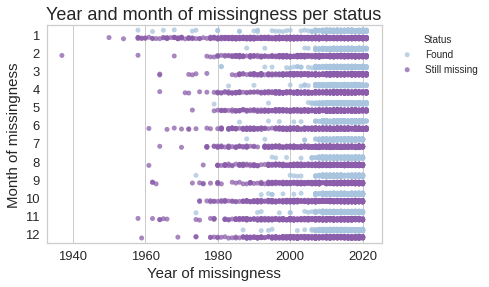

In [ ]:
# Figure of distribution of "Found" and "Still missing" across year of report
# and separately for month
sns.stripplot(x = "año", y = "mes", hue = "status",
              data = datos, dodge = True, alpha = .75,
              size = 5, palette = "BuPu")
plt.xlabel("Year of missingness", size = 15)
plt.ylabel("Month of missingness", size = 15)
plt.title("Year and month of missingness per status", size = 18)
plt.yticks(size = 13)
plt.xticks(size = 13)
plt.legend(title = "Status", bbox_to_anchor = (1.02, 1),
           labels = ("Found", "Still missing"))
plt.savefig('stripplot_date.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

In [ ]:
# Drop the column "month"
datos = datos.drop('mes', 1)

In [ ]:
# (Revision) Exclude data from before 2000 <========================= [OPTIONAL]
datos = datos[datos.año >= 2000]

In [ ]:
# Calculate the difference in years with respect to the current one (2021)
datos.año = 2021 - datos.año

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

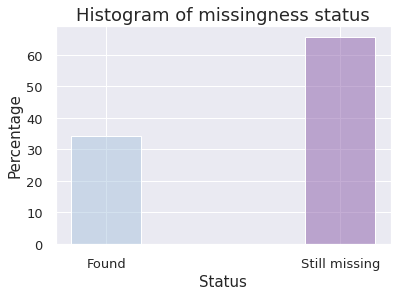

In [ ]:
# Verify distribution per missingness status
sns.set(style = "darkgrid")
sns.histplot(datos, x = "status", stat = "percent", hue = "status",
             palette = "BuPu", shrink = 0.3, legend = False)
plt.xlabel("Status", size = 15)
plt.ylabel("Percentage", size = 15)
plt.title("Histogram of missingness status", size = 18)
plt.xticks(ticks = (0, 1), labels = ("Found", "Still missing"), size = 13)
plt.yticks(size = 13)

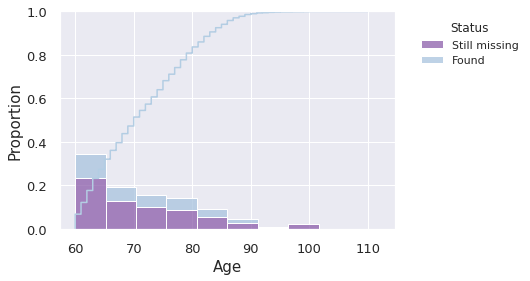

In [ ]:
# Histogram of age by status
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = datos, x = 'edad', stat = 'proportion', hue = 'status',
                palette = "BuPu", multiple = "stack", bins = 10, kde = False)
plt.xlabel("Age", size = 15)
plt.ylabel("Proportion", size = 15)
plt.legend(title = "Status", bbox_to_anchor = (1.4, 1),
           #labels = datos.status.unique())
           labels = ("Still missing", "Found"))
plt.xticks(size = 13)
plt.yticks(size = 13)
sns.ecdfplot(data = datos[datos.status == "Aparecio Vivo"], x = "edad",
             complementary = False, color = "#b3cde3")
plt.savefig('hist_age.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

(array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 8 Text major ticklabel objects>)

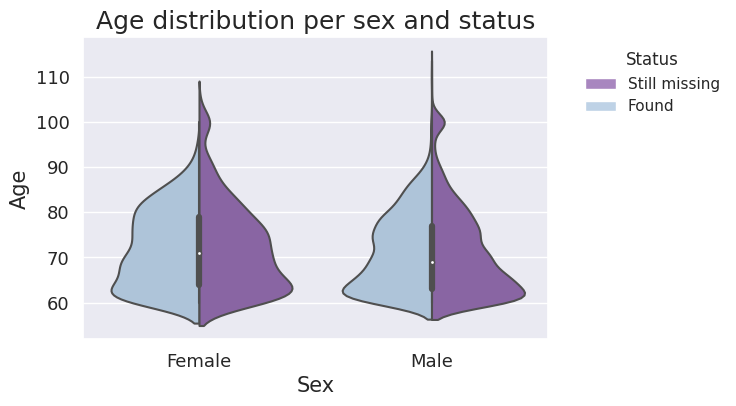

In [ ]:
# Violin plot of the distribution by age of "Found" examples, split by sex
sns.set(style = "darkgrid")
sns.violinplot(x = "sexo", y = "edad", hue = "status",
                    data = datos, palette = "BuPu", split = True,
               saturation = 0.8, inner = "box",
               order = ("Mujer", "Hombre"))
plt.xlabel("Sex", size = 15)
plt.ylabel("Age", size = 15)
plt.legend(handles = ax.legend_.legendHandles,
           labels = ["Still missing", "Found"], title = "Status",
           bbox_to_anchor = (1.4, 1))
plt.title("Age distribution per sex and status", size = 18)
plt.xticks(ticks = (0, 1), labels = ("Female", "Male"), size = 13)
plt.yticks(size = 13)

([<matplotlib.axis.XTick at 0x7f17e8759e90>,
 [Text(0, 0, 'Found'), Text(0, 0, 'Still missing')])

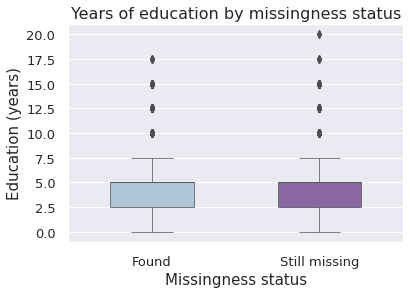

In [ ]:
# Boxplot of education distribution
sns.set(style = "darkgrid")
sns.boxplot(data = datos, x = "status", y = "escolaridad", palette = "BuPu",
            linewidth = 0.7, width = 0.5)
plt.xlabel("Missingness status", size = 15)
plt.ylabel("Education (years)", size = 15)
plt.title("Years of education by missingness status", size = 16)
plt.yticks(size = 13)
plt.xticks(ticks = (0, 1), labels = ("Found", "Still missing"), size = 13)

([<matplotlib.axis.XTick at 0x7f17e86ac090>,
 [Text(0, 0, 'current'), Text(0, 0, 'none'), Text(0, 0, 'past')])

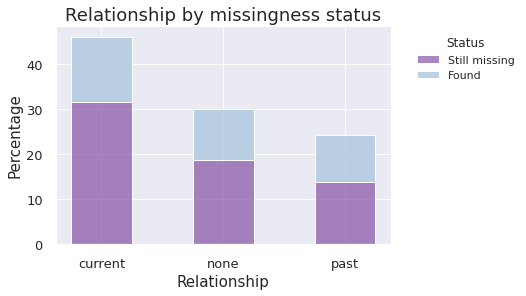

In [ ]:
# Missingness status by relationship status
sns.set(style = "darkgrid")
sns.histplot(datos, x = "relacion", hue = "status", multiple = "stack",
                 stat = "percent", palette = "BuPu", shrink = 0.5)
plt.xlabel("Relationship", size = 15)
plt.ylabel("Percentage", size = 15)
plt.legend(title = "Status", bbox_to_anchor = (1.4, 1),
           labels = ("Still missing", "Found"))
plt.title("Relationship by missingness status", size = 18)
plt.yticks(size = 13)
plt.xticks(ticks = (0, 1, 2), labels = ("current", "none", "past"), size = 13)

([<matplotlib.axis.XTick at 0x7f17e7f07890>,
 [Text(0, 0, 'No'), Text(0, 0, 'Yes')])

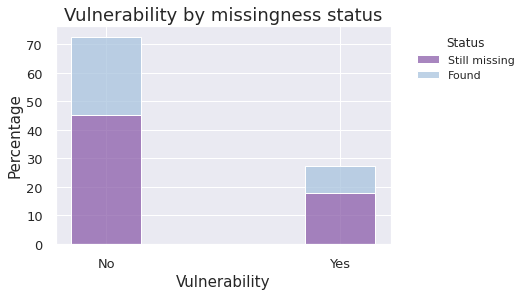

In [ ]:
# Missingness status by vulnerability
sns.set(style = "darkgrid")
sns.histplot(datos, x = "vulnerabilidad", hue = "status", multiple = "stack",
                 stat = "percent", palette = "BuPu", shrink = 0.3)
plt.xlabel("Vulnerability", size = 15)
plt.ylabel("Percentage", size = 15)
plt.legend(title = "Status", bbox_to_anchor = (1.4, 1),
           labels = ("Still missing", "Found"))
plt.title("Vulnerability by missingness status", size = 18)
plt.yticks(size = 13)
plt.xticks(ticks = (0, 1), labels = ("No", "Yes"), size = 13)

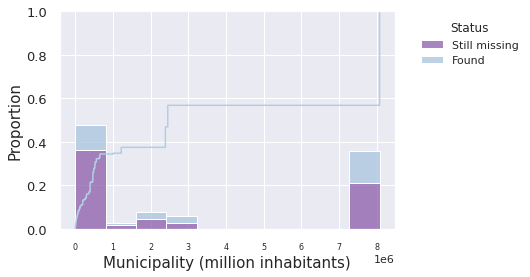

In [ ]:
# Municipality size
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = datos, x = 'municipio', stat = 'proportion', hue = 'status',
                palette = "BuPu", multiple = "stack", bins = 10, kde = False)
plt.xlabel("Municipality (million inhabitants)", size = 15)
plt.ylabel("Proportion", size = 15)
plt.legend(title = "Status",
           labels = ("Still missing", "Found"),
           bbox_to_anchor = (1.4, 1))
plt.xticks(size = 8)
plt.yticks(size = 13)
sns.ecdfplot(data = datos[datos.status == "Aparecio Vivo"], x = "municipio",
             complementary = False, ax = ax, color = "#b3cde3")
plt.savefig('hist_municipality.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

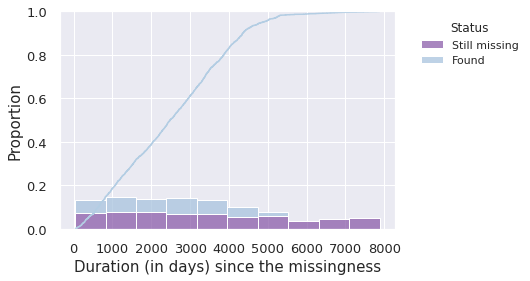

In [ ]:
# "Duration" (time elapsed since the missingness report) distribution
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = datos, x = 'dias', stat = 'proportion', hue = 'status',
                palette = "BuPu", multiple = "stack", bins = 10, kde = False)
plt.xlabel("Duration (in days) since the missingness", size = 15)
plt.ylabel("Proportion", size = 15)
plt.legend(title = "Status", bbox_to_anchor = (1.4, 1),
           labels = ("Still missing", "Found"))
plt.xticks(size = 13)
plt.yticks(size = 13)
sns.ecdfplot(data = datos[datos.status == "Aparecio Vivo"], x = "dias",
             complementary = False, ax = ax, color = "#b3cde3")
plt.savefig('hist_days.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

In [ ]:
# Create numeric output variable
datos['aparecio'] = np.where(datos['status'] == 'Aparecio Vivo', 1, 0)

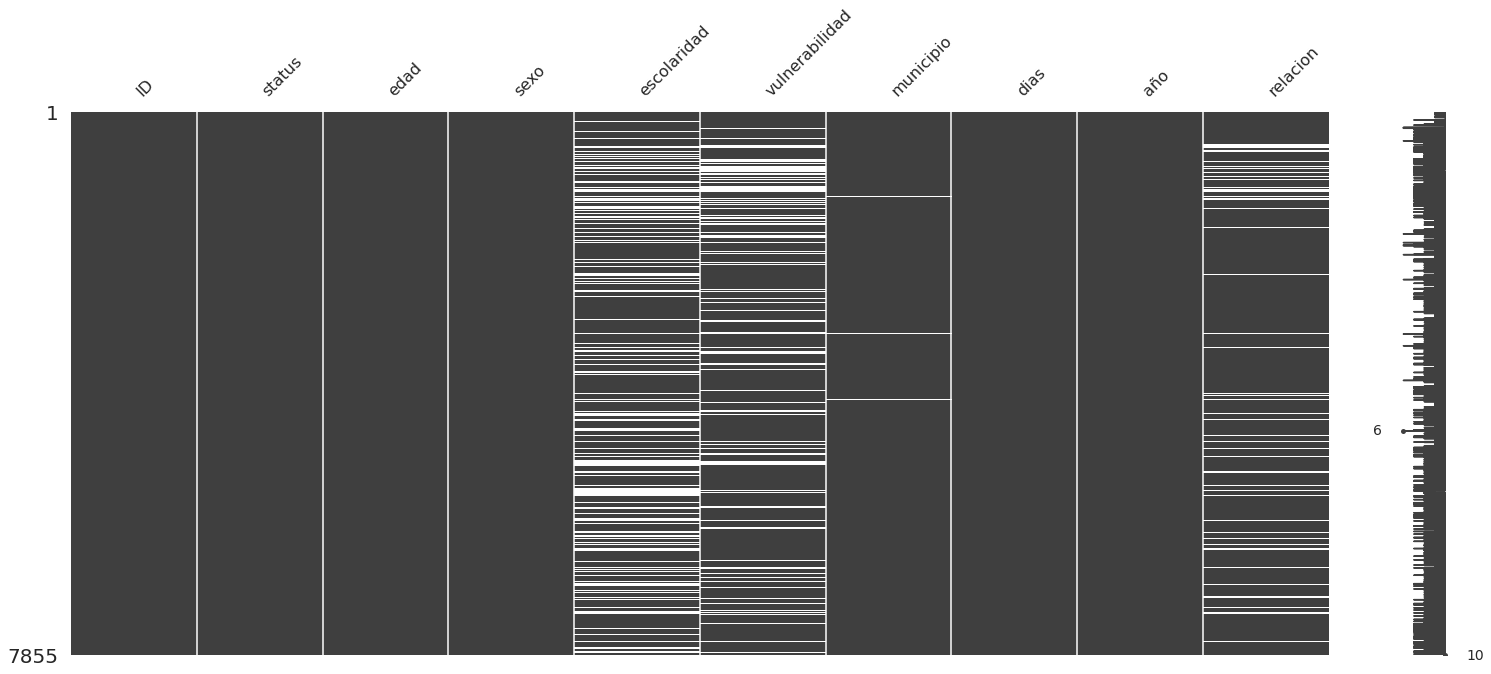

In [ ]:
# Visualize pattern of missing values
msno.matrix(datos)

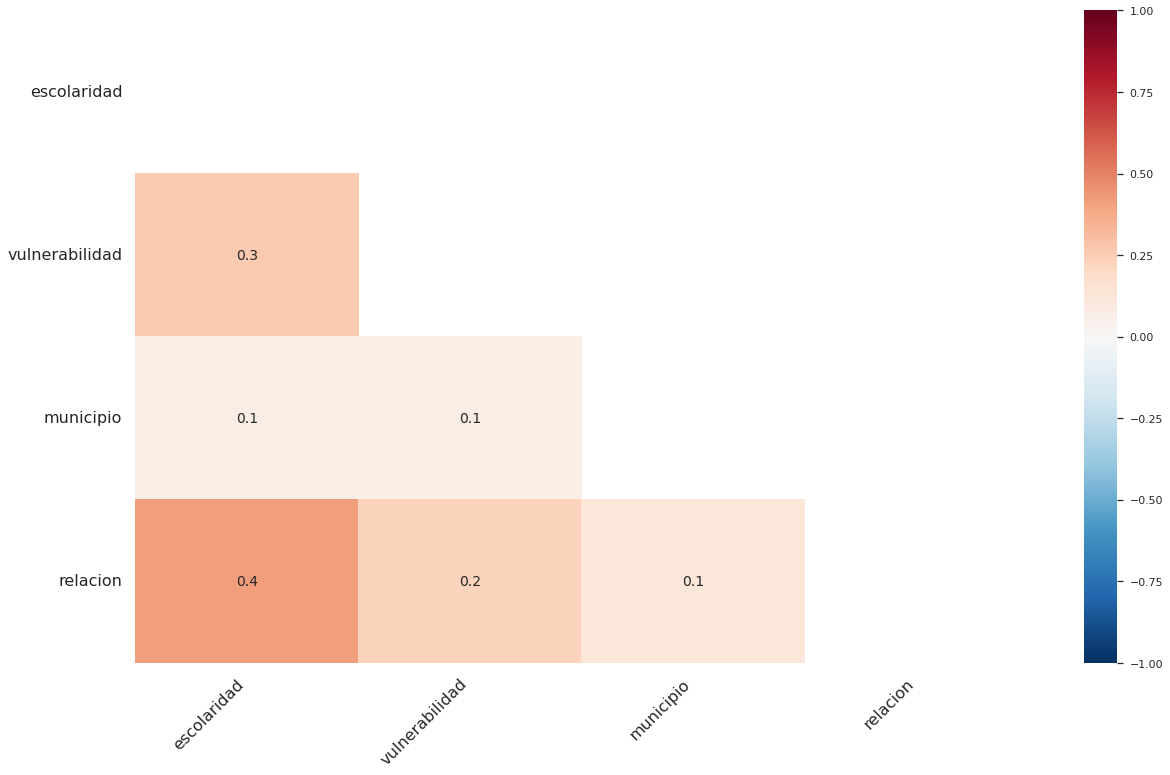

In [ ]:
# Visualize relationships between variables with missing values
msno.heatmap(datos, cmap = plt.get_cmap('RdBu').reversed())

- **Multivariate (Sweetviz)**

In [ ]:
# Install Sweetviz
!pip install sweetviz &> /dev/null

In [ ]:
# Import Sweetviz and create the report ("Found" is the output variable)
import sweetviz as sv
reporte = sv.analyze(datos.loc[:, datos.columns != 'ID'], "aparecio")

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



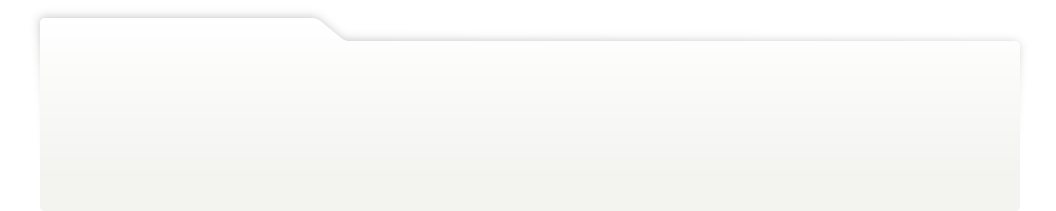
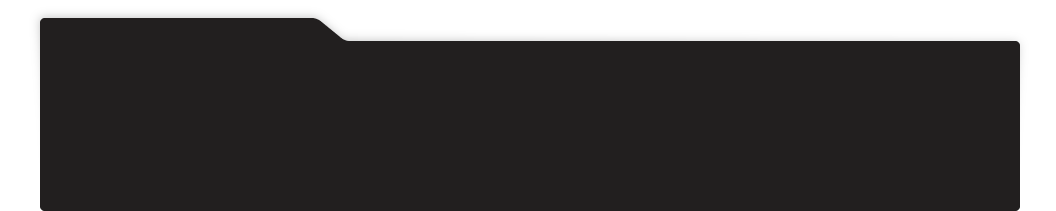
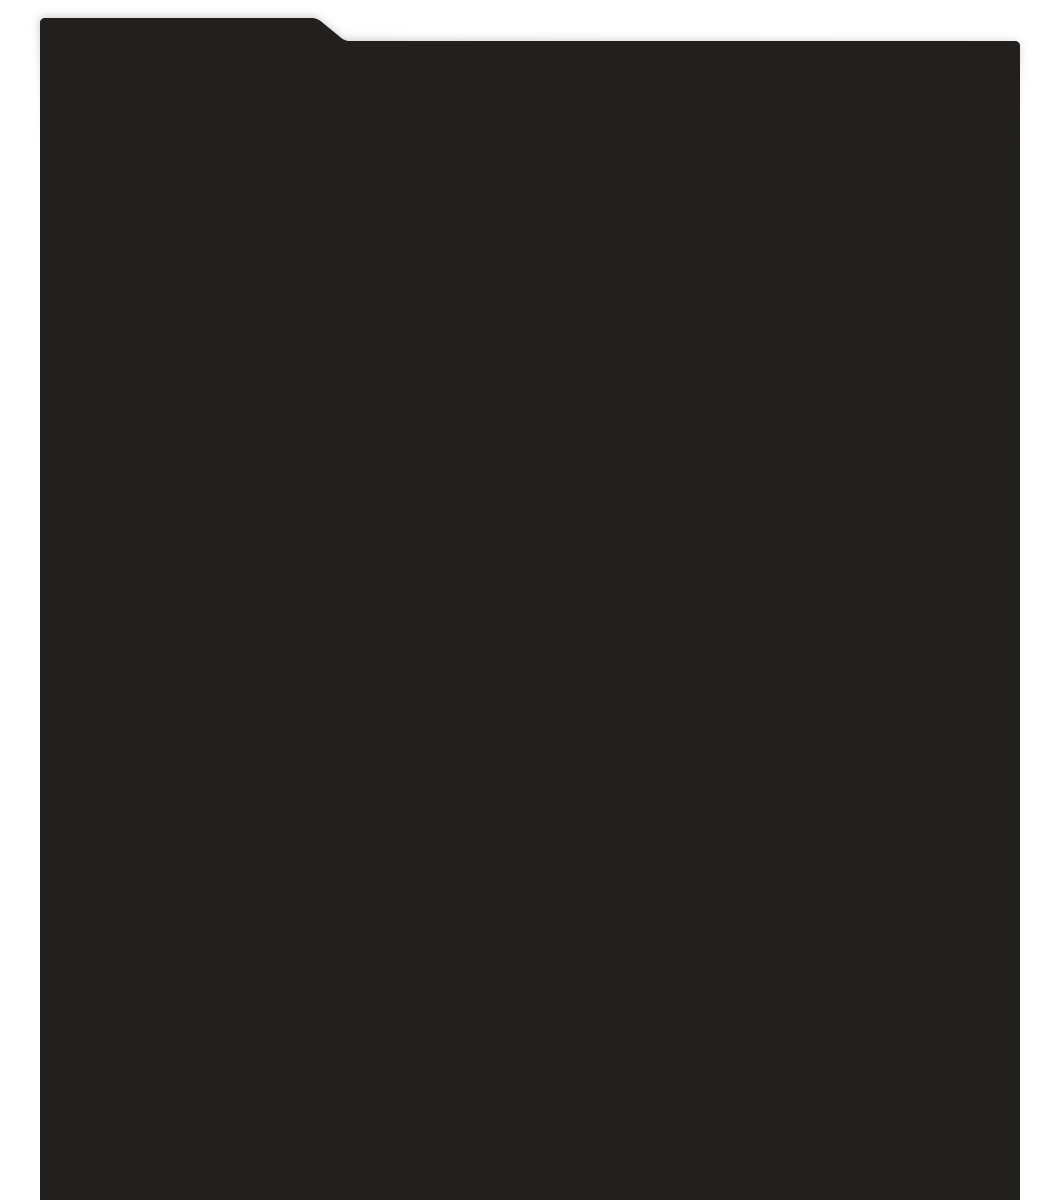
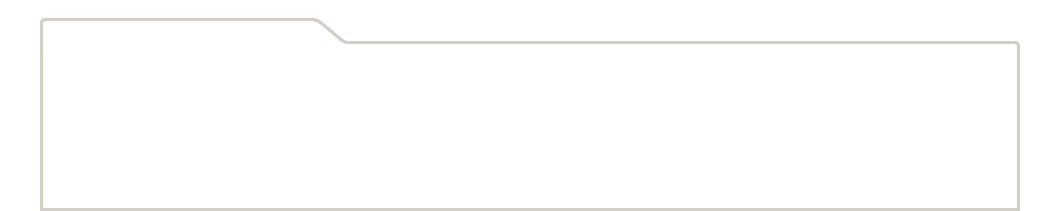
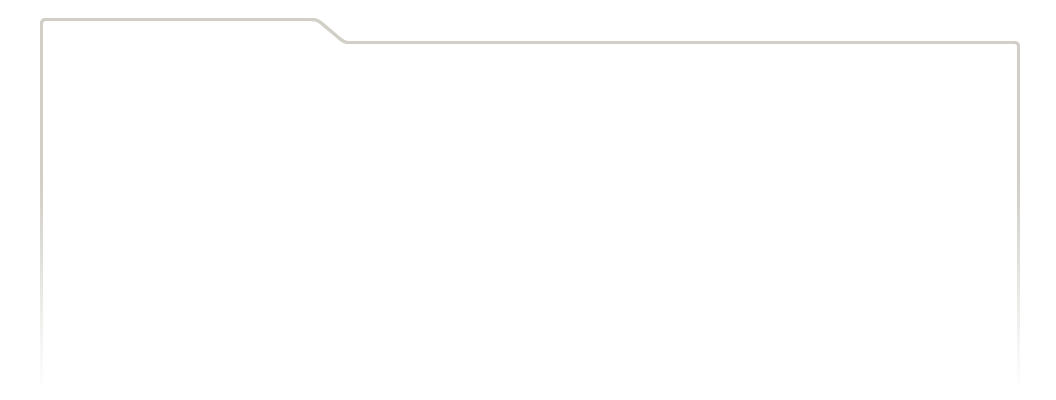
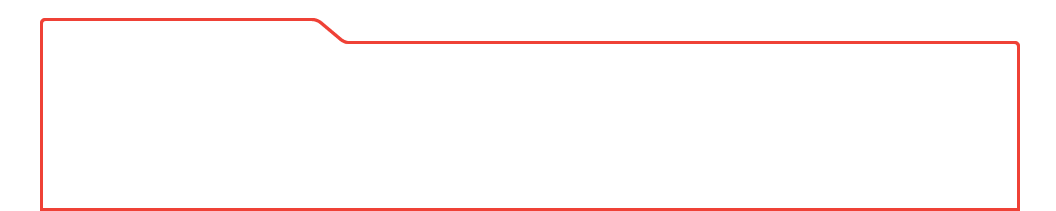
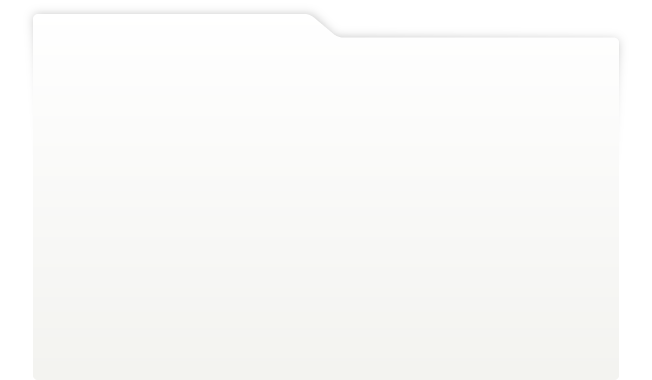
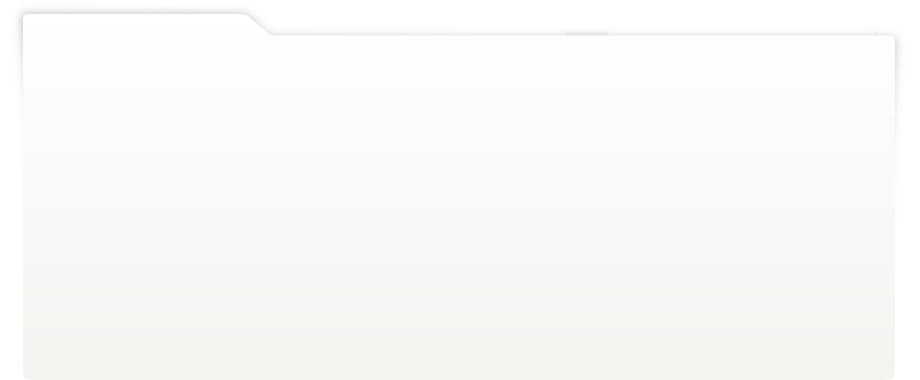
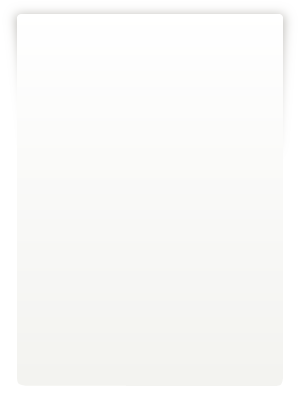
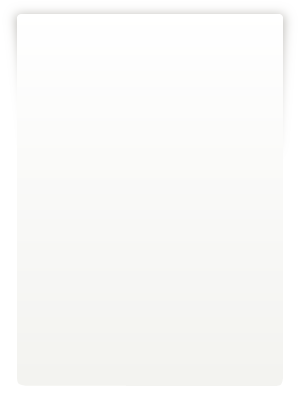
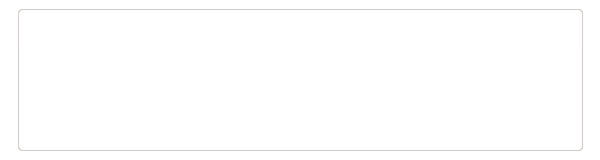
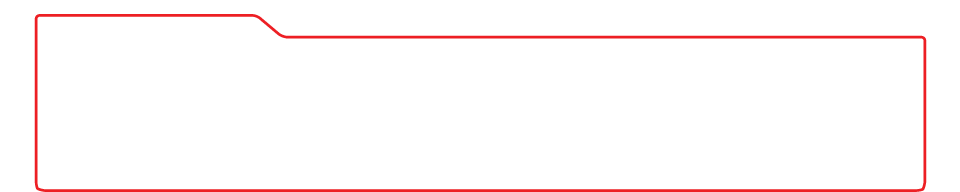
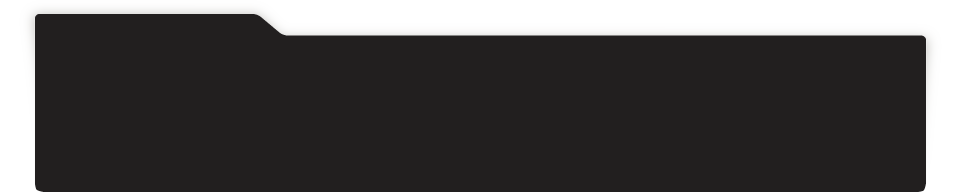
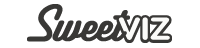
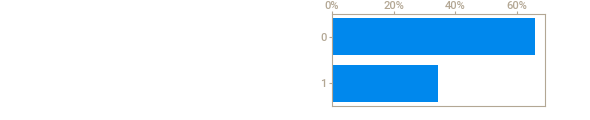
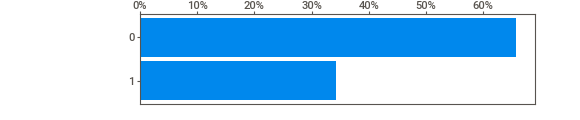
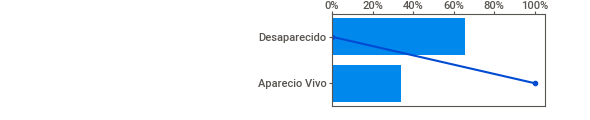
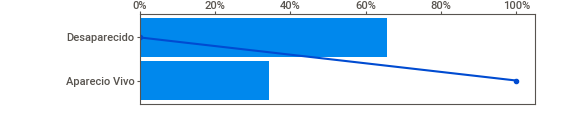
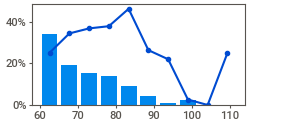
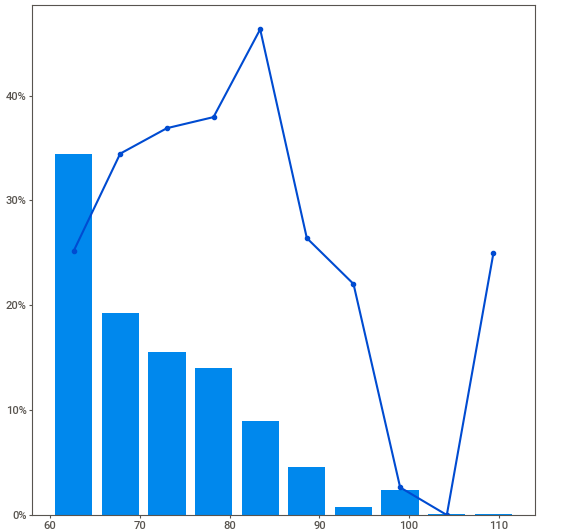
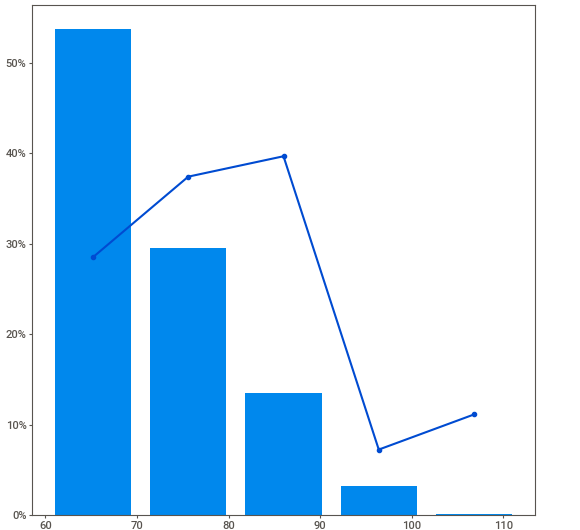
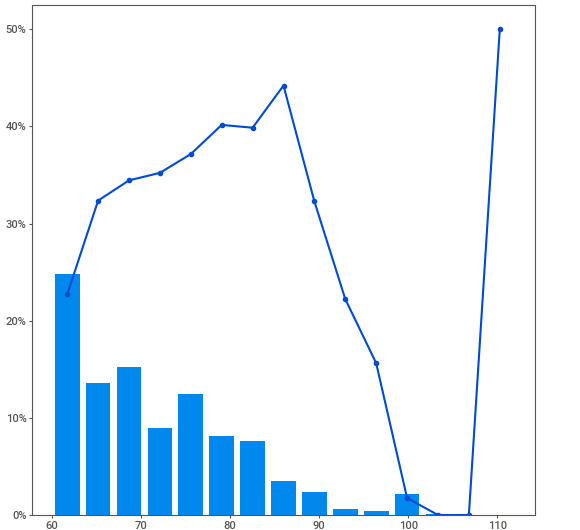
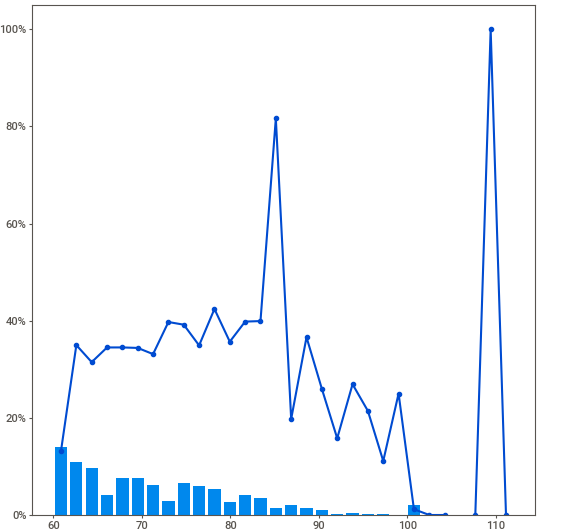
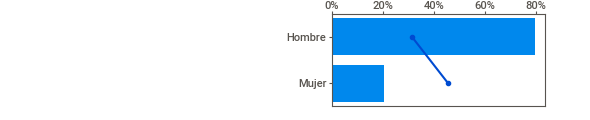
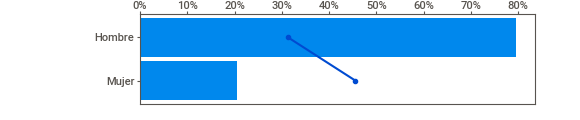
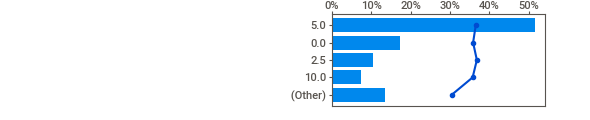
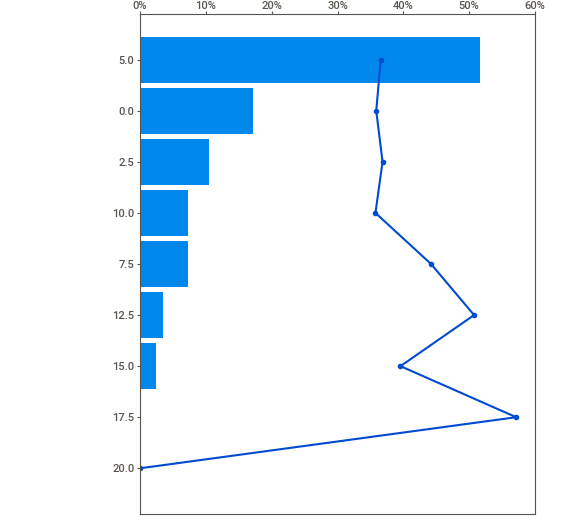
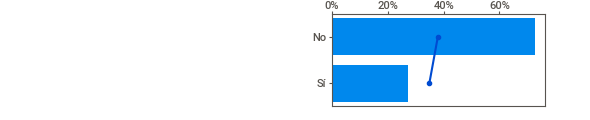
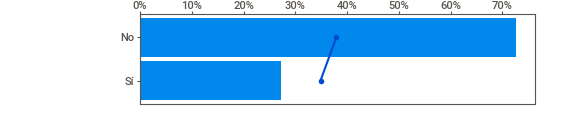
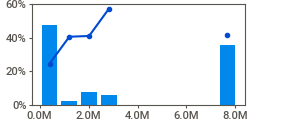
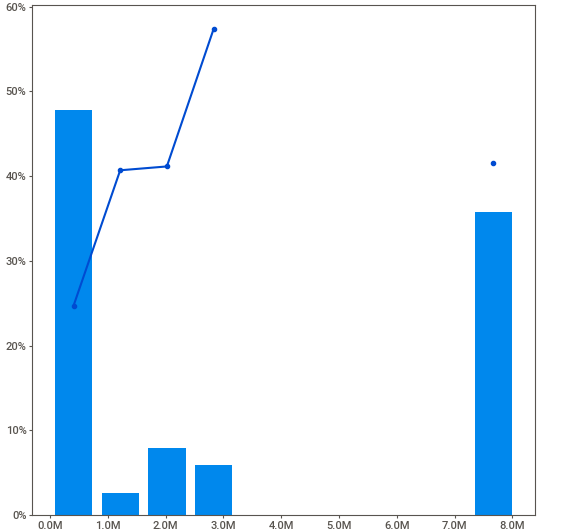
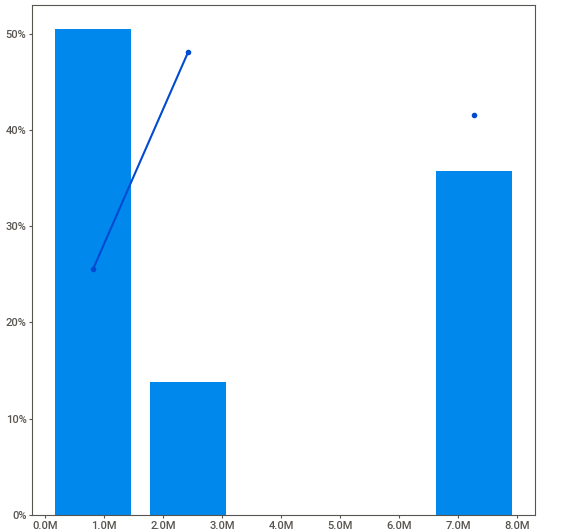
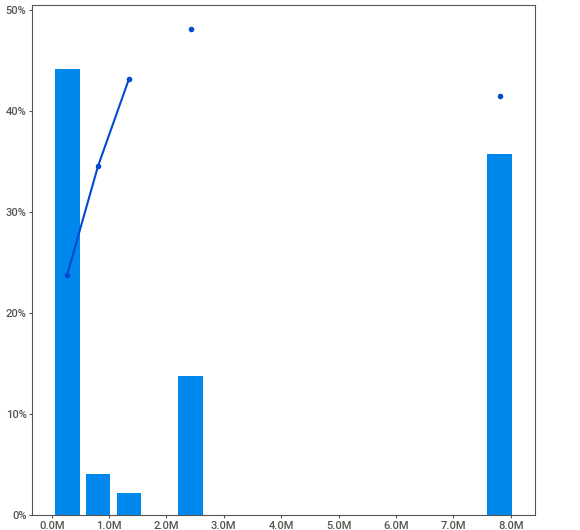
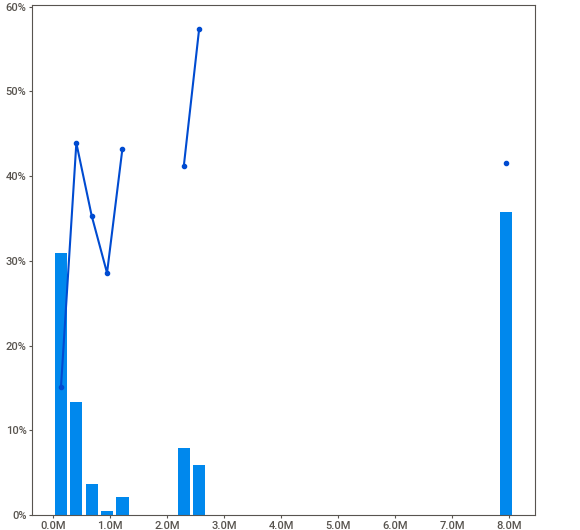
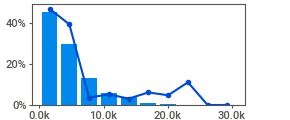
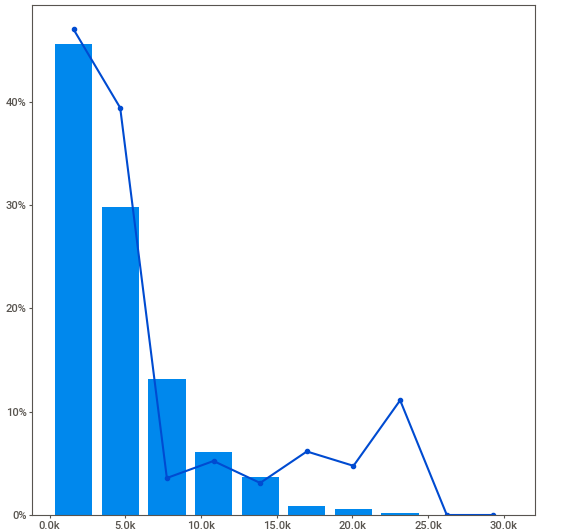
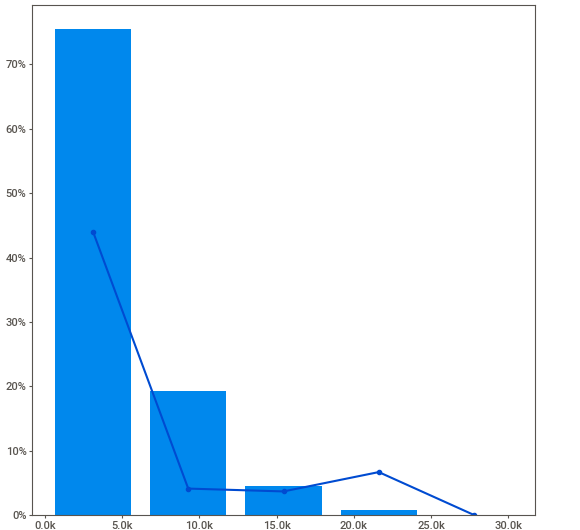
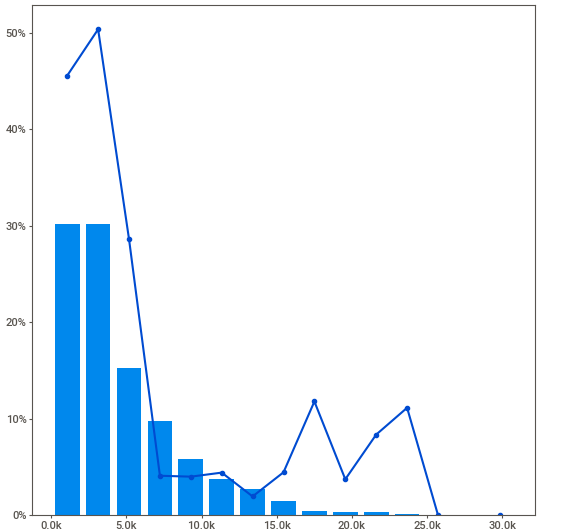
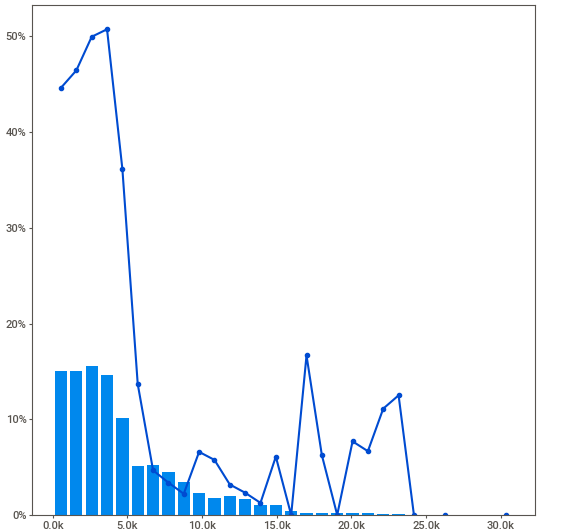
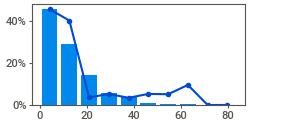
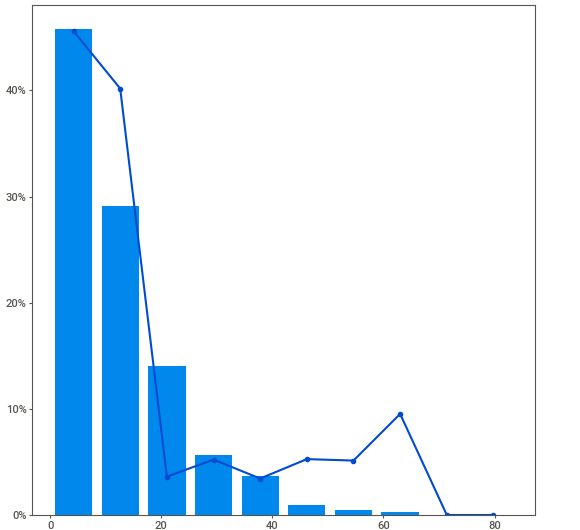
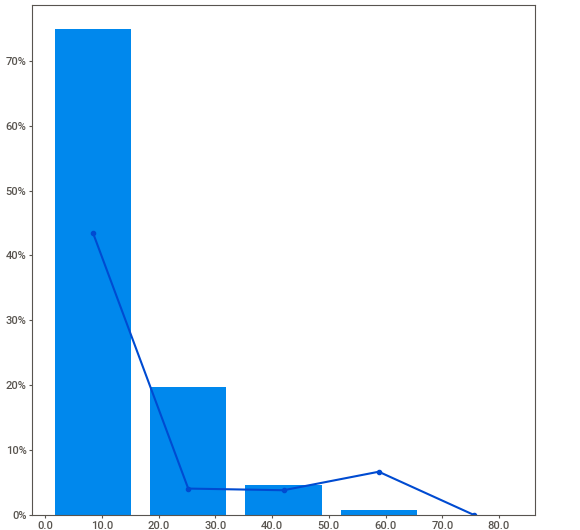
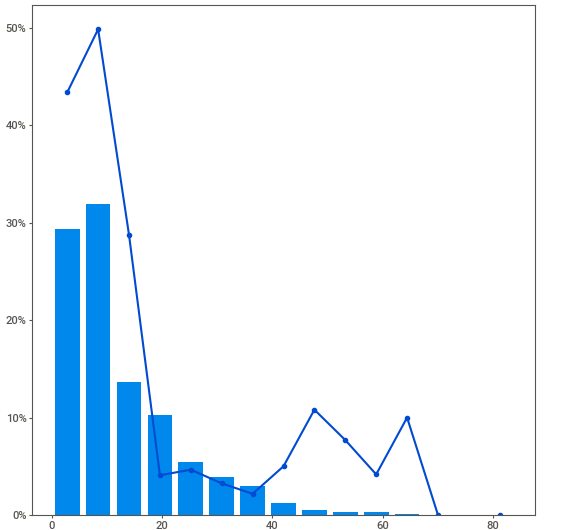
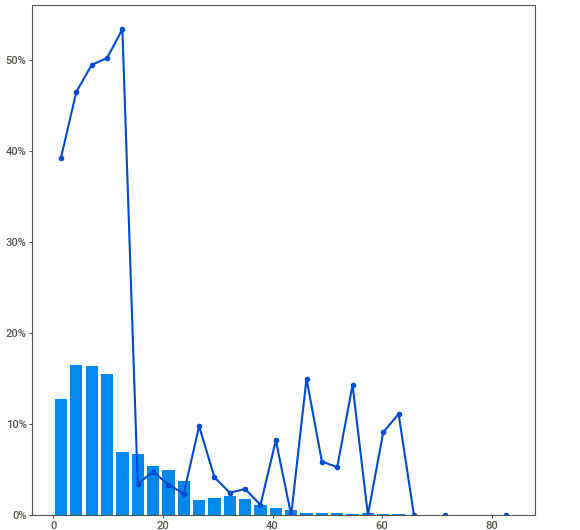
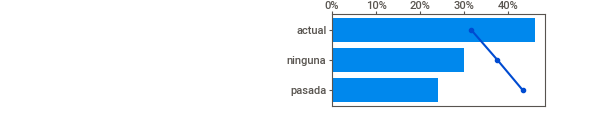
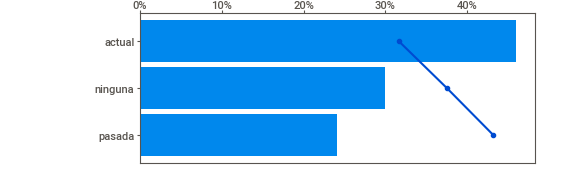
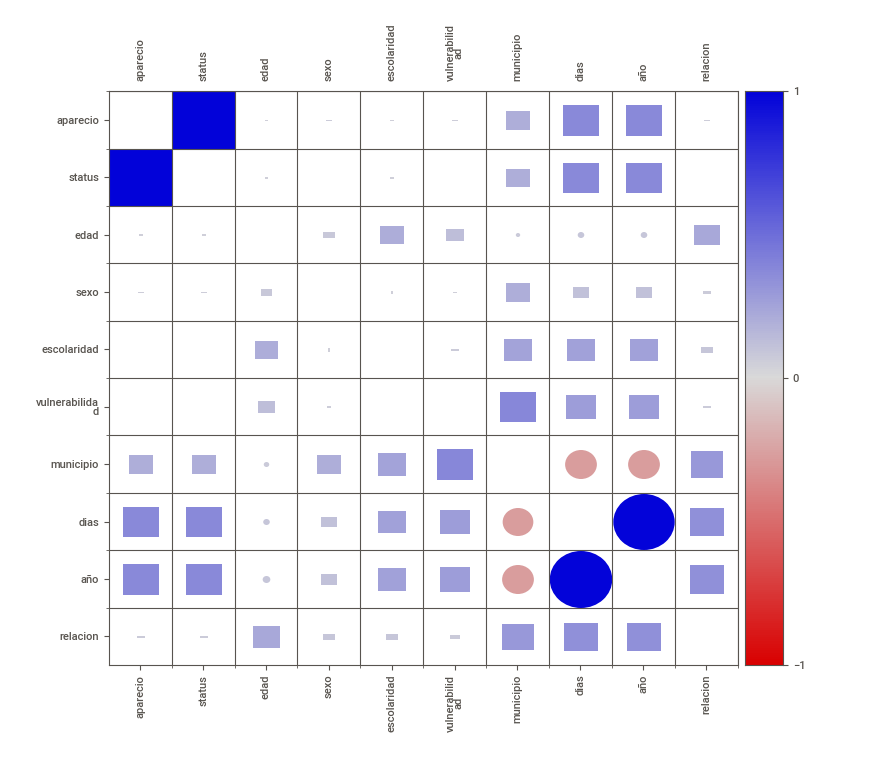
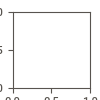

In [ ]:
# Show report
reporte.show_html()
display(HTML('SWEETVIZ_REPORT.html'))

## **7 Split data into training and testing sets**
---

Randomly generate a training and a testing set to ensure independence of both before doing feature engineering. This step will ensure no data leakage.

In [ ]:
# Create training and testing sets stratifying by the output variable "y"
X = datos.drop("aparecio", axis = 1)
y = datos["aparecio"].copy()
X = X.drop(["ID", "status", "año"], axis = 1)  # ID is related to year
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.2,
                                                    random_state = 2021)

In [ ]:
# Check that the percentage of null examples as well as the labels are
# the same in both sets

# Training
clase_train = (y_train == 0)

# Testing
clase_test = (y_test == 0)

# Result
print("The percentage of examples with status 'Still missing' in",
      "the training data set is:",
      np.round(((len(y_train[clase_train == True]) / len(y_train)) * 100), 2))
print("The percentage of examples with status 'Still missing' in",
      "the testing data set is:",
      np.round(((len(y_test[clase_test == True]) / len(y_test)) * 100), 2))

The percentage of examples with status 'Still missing' in the training data set is: 65.77
The percentage of examples with status 'Still missing' in the testing data set is: 65.75


## **8 Impute missing values in the training data**
---

### **a. Education**

In [ ]:
# Imputation by the mean 
imp_edu = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_edu.fit(X_train[['escolaridad']])
SimpleImputer()
X_train['escolaridad'] = imp_edu.transform(X_train[['escolaridad']]).flatten()
X_train.isnull().sum()

edad                 0
sexo                 0
escolaridad          0
vulnerabilidad    1164
municipio           22
dias                 0
relacion           645
dtype: int64

In [ ]:
# Replace missing values in the testing data set using the mean of the
# **training** data set
X_test['escolaridad'] = X_test['escolaridad'].replace(np.nan, X_train['escolaridad'].mean())
X_test.isnull().sum()

edad                0
sexo                0
escolaridad         0
vulnerabilidad    310
municipio          10
dias                0
relacion          168
dtype: int64

### **b. Municipality**

In [ ]:
# Impute using the mean 
imp_mun = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mun.fit(X_train[['municipio']])
SimpleImputer()
X_train.loc[X_train['municipio'].isna(), 'municipio'] =\
imp_mun.transform(np.array(X_train.municipio[X_train['municipio'].isna()]).reshape(-1, 1))
X_train.isnull().sum()

edad                 0
sexo                 0
escolaridad          0
vulnerabilidad    1164
municipio            0
dias                 0
relacion           645
dtype: int64

In [ ]:
# Replace missing values in the testing data set using the mean in the
# *training* data set
X_test['municipio'] = X_test['municipio'].fillna(X_train.loc[:, 'municipio'].mean())
X_test.isnull().sum()

edad                0
sexo                0
escolaridad         0
vulnerabilidad    310
municipio           0
dias                0
relacion          168
dtype: int64

### **c. Vulnerability**

In [ ]:
# Impute with the mode
imp_vul = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imp_vul.fit(X_train[['vulnerabilidad']])
SimpleImputer()
X_train['vulnerabilidad'] = imp_vul.transform(X_train[['vulnerabilidad']])
X_train['vulnerabilidad'] = X_train['vulnerabilidad'].astype("category")
X_train.isnull().sum()

edad                0
sexo                0
escolaridad         0
vulnerabilidad      0
municipio           0
dias                0
relacion          645
dtype: int64

In [ ]:
# Replace missing values in the testing data set using the mode of the
# **training** data set
X_test['vulnerabilidad'] = X_test['vulnerabilidad'].fillna(X_train.loc[:, 'vulnerabilidad'].mode()[0])
X_test.isnull().sum()

edad                0
sexo                0
escolaridad         0
vulnerabilidad      0
municipio           0
dias                0
relacion          168
dtype: int64

### **d. Relationship status**

In [ ]:
# Impute with the mode
imp_rel = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imp_rel.fit(X_train[['relacion']])
SimpleImputer()
X_train['relacion'] = imp_rel.transform(X_train[['relacion']])
X_train['relacion'] = X_train['relacion'].astype("category")
X_train.isnull().sum()

edad              0
sexo              0
escolaridad       0
vulnerabilidad    0
municipio         0
dias              0
relacion          0
dtype: int64

In [ ]:
# Replace missing values in the testing data set using the mode in the
# **training** data set
X_test['relacion'] = X_test.relacion.fillna(X_train.relacion.mode().iloc[0])
X_test.isnull().sum()

edad              0
sexo              0
escolaridad       0
vulnerabilidad    0
municipio         0
dias              0
relacion          0
dtype: int64

## **9 Reference or base (rule-based) model**
---

Following the descriptive analysis, we propose a reference (or base) model whereby if the missingness has an elapsed time (in days) equal or less than the mean of the elapse time since the missingness in the training data, then we can predict that a missing person is going to be found. This rule is thought to reflect the *temporal context* of the missingness.

### **a. Create the base model**
Mean of elapsed time (in days) since the missingness

In [ ]:
# Base model (training data set)
base = pd.concat([X_train, y_train], axis = 1)
base['aparecio_pred'] = (base.dias <= np.mean(base.dias)).astype(int)
base

,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,aparecio,aparecio_pred
9852,77,Hombre,4.966056,No,463218.0,8011,actual,0,0
61048,74,Mujer,0.000000,No,8076734.0,3634,pasada,0,1
63103,80,Mujer,5.000000,No,522442.0,4564,ninguna,1,0
122817,84,Hombre,4.966056,No,2457680.0,1593,pasada,1,1
104533,74,Hombre,2.500000,No,8076734.0,2271,pasada,1,1
...,...,...,...,...,...,...,...,...,...
119036,78,Hombre,5.000000,No,8076734.0,1732,actual,0,1
110709,76,Hombre,0.000000,Sí,200829.0,2371,actual,0,1
52947,77,Mujer,5.000000,No,8076734.0,3852,pasada,1,1
1091,77,Hombre,5.000000,No,8076734.0,5240,pasada,0,0


In [ ]:
# Base model (testing data set)
base_test = pd.concat([X_test, y_test], axis = 1)
base_test['aparecio_pred'] = (base_test.dias <= np.mean(base.dias)).astype(int)
base_test

,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,aparecio,aparecio_pred
149087,63,Mujer,4.966056,Sí,36708.0,7872,ninguna,0,0
10621,100,Hombre,4.966056,No,491387.0,6451,ninguna,0,0
84654,71,Hombre,5.000000,No,18678.0,7724,actual,0,0
123355,72,Hombre,4.966056,No,2394870.0,1576,ninguna,0,1
82512,60,Hombre,15.000000,No,2457680.0,6672,actual,0,0
...,...,...,...,...,...,...,...,...,...
84409,63,Mujer,4.966056,No,495200.0,2941,ninguna,1,1
101399,77,Hombre,10.000000,Sí,8076734.0,2339,actual,0,1
85655,86,Mujer,0.000000,No,8076734.0,2882,pasada,1,1
24131,62,Hombre,4.966056,No,562704.0,9467,actual,1,0


### **b. Result of the reference model**

In [ ]:
# Show only the columns with the true values of the output variable
# ("Found") and the values that the reference model predicts ("aparecio_pred")
filtro_columnas = ['aparecio', 'aparecio_pred']
base_test[filtro_columnas]

,aparecio,aparecio_pred
149087,0,0
10621,0,0
84654,0,0
123355,0,1
82512,0,0
...,...,...
84409,1,1
101399,0,1
85655,1,1
24131,1,0


### **c. Assessment of the reference model**

In [ ]:
# Assessment of the reference model in the **testing** data set
print("Evaluation metrics of the reference model:", "\n"
      "accuracy  =", np.around(accuracy_score(base_test.aparecio, base_test.aparecio_pred),
                               2), "\n"
      "precision =", np.around(precision_score(base_test.aparecio, base_test.aparecio_pred),
                               2), "\n"
      "recall    =", np. around(recall_score(base_test.aparecio, base_test.aparecio_pred),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(base_test.aparecio, base_test.aparecio_pred),
                               2), "\n"
      "F1 score  =", np.around(f1_score(base_test.aparecio, base_test.aparecio_pred), 2))

Evaluation metrics of the reference model: 
accuracy  = 0.63 
precision = 0.48 
recall    = 0.89 
ROC AUC   = 0.69 
F1 score  = 0.62


### **d. Confusion matrix of the reference model**

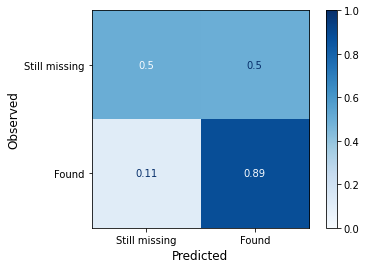

In [ ]:
# Plot the confusion matrix of the reference model
sns.reset_orig()
cm = confusion_matrix(base_test.aparecio, base_test.aparecio_pred,
                      normalize = "true")
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ["Still missing",
                                                "Found"])
disp.plot(cmap = plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(0, 1)
plt.xlabel("Predicted", size = 12)
plt.ylabel("Observed", size = 12)
plt.savefig('confusion_matrix_base_model.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

## **10 Feature engineering**
---

### **a. Training data**

In [ ]:
# One Hot Encoder: Categorical data
X_train['sexo'] = X_train['sexo'].astype("category")
categorical_features = ["sexo", "relacion", "vulnerabilidad"]
enc = OneHotEncoder(drop = 'if_binary')
enc.fit(X_train[categorical_features])
encoded_columns = enc.transform(X_train[categorical_features]).toarray()
data_hot_encoded = pd.DataFrame(encoded_columns, index = X_train.index,
                                columns = enc.get_feature_names())
data_hot_encoded

,x0_Mujer,x1_actual,x1_ninguna,x1_pasada,x2_Sí
9852,0.0,1.0,0.0,0.0,0.0
61048,1.0,0.0,0.0,1.0,0.0
63103,1.0,0.0,1.0,0.0,0.0
122817,0.0,0.0,0.0,1.0,0.0
104533,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
119036,0.0,1.0,0.0,0.0,0.0
110709,0.0,1.0,0.0,0.0,1.0
52947,1.0,0.0,0.0,1.0,0.0
1091,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Standard Scaler: Numeric data
numeric_features = ["edad", "escolaridad", "municipio", "dias"]
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
scaler_columns = scaler.transform(X_train[numeric_features])
data_scaled = pd.DataFrame(scaler_columns, index = X_train.index,
                           columns = numeric_features)
data_scaled

,edad,escolaridad,municipio,dias
9852,0.593890,0.000000,-0.803367,0.916313
61048,0.275541,-1.672331,1.308581,-0.217883
63103,0.912239,0.011431,-0.786939,0.023105
122817,1.336704,0.000000,-0.250114,-0.746759
104533,0.275541,-0.830450,1.308581,-0.571072
...,...,...,...,...
119036,0.700006,0.011431,1.308581,-0.710741
110709,0.487774,-1.672331,-0.876152,-0.545159
52947,0.593890,0.011431,1.308581,-0.161393
1091,0.593890,0.011431,1.308581,0.198274


In [ ]:
# Combine both transformations
X_train_proc = pd.concat([data_hot_encoded, data_scaled], axis = 1)
X_train_proc.describe()

,x0_Mujer,x1_actual,x1_ninguna,x1_pasada,x2_Sí,edad,escolaridad,municipio,dias
count,6284.000000,6284.000000,6284.000000,6284.000000,6284.000000,6.284000e+03,6.284000e+03,6.284000e+03,6.284000e+03
mean,0.199714,0.515118,0.270369,0.214513,0.222788,6.862924e-16,-2.282139e-17,3.922176e-17,-8.612885e-17
std,0.399817,0.499811,0.444186,0.410517,0.416150,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.210087e+00,-1.672331e+00,-9.315152e-01,-1.149182e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-8.917384e-01,0.000000e+00,-8.999617e-01,-7.164415e-01
50%,0.000000,1.000000,0.000000,0.000000,0.000000,-1.489242e-01,1.143071e-02,-5.923393e-01,-2.799433e-01
75%,0.000000,1.000000,1.000000,0.000000,0.000000,5.938900e-01,1.143071e-02,1.308581e+00,4.174302e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.307961e+00,5.062716e+00,1.308581e+00,6.837089e+00


In [ ]:
# Label transformation with Label Encoder
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_train_enc # 0 = Desaparecido; 1 = Apareció vivo

array([0, 0, 1, ..., 1, 0, 1])

### **b. Testing data**

In [ ]:
# One Hot Encoder: Categorical data
X_test['sexo'] = X_test['sexo'].astype("category")
encoded_columns_test = enc.transform(X_test[categorical_features]).toarray()
data_hot_encoded_test = pd.DataFrame(encoded_columns_test, index = X_test.index,
                                columns = enc.get_feature_names())
data_hot_encoded_test

,x0_Mujer,x1_actual,x1_ninguna,x1_pasada,x2_Sí
149087,1.0,0.0,1.0,0.0,1.0
10621,0.0,0.0,1.0,0.0,0.0
84654,0.0,1.0,0.0,0.0,0.0
123355,0.0,0.0,1.0,0.0,0.0
82512,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
84409,1.0,0.0,1.0,0.0,0.0
101399,0.0,1.0,0.0,0.0,1.0
85655,1.0,0.0,0.0,1.0,0.0
24131,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Standard Scaler: Numeric data
scaler_columns_test = scaler.transform(X_test[numeric_features])
data_scaled_test = pd.DataFrame(scaler_columns_test, index = X_test.index,
                           columns = numeric_features)
data_scaled_test

,edad,escolaridad,municipio,dias
149087,-0.891738,-5.652918e-14,-0.921678,0.880295
10621,3.034565,-5.652918e-14,-0.795553,0.512076
84654,-0.042808,1.143071e-02,-0.926680,0.841944
123355,0.063308,-5.652918e-14,-0.267537,-0.751164
82512,-1.210087,3.378955e+00,-0.250114,0.569343
...,...,...,...,...
84409,-0.891738,-5.652918e-14,-0.794495,-0.397457
101399,0.593890,1.695193e+00,1.308581,-0.553451
85655,1.548937,-1.672331e+00,1.308581,-0.412746
24131,-0.997855,-5.652918e-14,-0.775770,1.293601


In [ ]:
# Combine both transformations
X_test_proc = pd.concat([data_hot_encoded_test, data_scaled_test], axis = 1)
X_test_proc.describe()

,x0_Mujer,x1_actual,x1_ninguna,x1_pasada,x2_Sí,edad,escolaridad,municipio,dias
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1.571000e+03,1571.000000,1571.000000
mean,0.223425,0.518778,0.259071,0.222151,0.218332,0.007920,-1.851426e-02,-0.010065,0.009910
std,0.416673,0.499806,0.438264,0.415825,0.413246,0.996597,9.760040e-01,0.987535,0.982206
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.210087,-1.672331e+00,-0.931342,-1.148923
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785622,-5.652918e-14,-0.898011,-0.685476
50%,0.000000,1.000000,0.000000,0.000000,0.000000,-0.148924,1.143071e-02,-0.267537,-0.264784
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.593890,1.143071e-02,1.308581,0.406093
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.095728,3.378955e+00,1.308581,4.763043


In [ ]:
# Apply the label encoding fit in the training data labels to the testing data
# labels
y_test_enc = le.transform(y_test)
y_test_enc, le.inverse_transform(y_test_enc)

(array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 0, ..., 1, 1, 0]))

### **c. Subsampling: Class balancing in the training data**

In [ ]:
# Subsample training data to examine the effect of the relative
# class imbalance (though probably this isn't too severe)
under_sampler = RandomUnderSampler(random_state = 2021)
X_res, y_res = under_sampler.fit_resample(X_train_proc, y_train_enc)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test_enc)}")

Training target statistics: Counter({0: 2151, 1: 2151})
Testing target statistics: Counter({0: 1033, 1: 538})


## **11 Machine Learning Models**
---

**Target:** According to the *reference model (point 9)*, machine learning models should, ideally, be able to exceed some of these scores (which are already good):
- Accuracy = 0.63
- Precision = 0.48
- Recall = 0.89
- ROC = 0.69
- F1 score = 0.62

### **a. Global analysis with PyCaret**

In [ ]:
# Specify setup: SMOTE for imbalance
datos.aparecio = datos.aparecio.astype("category")
under_sampler = RandomUnderSampler(random_state = 2021)
clf1 = setup(data = datos, ignore_features = ["ID", "status", "año"],
             target = 'aparecio', train_size = 0.8,
             normalize = True, data_split_stratify = True,
             categorical_imputation = 'mode',
             ordinal_features = { 'vulnerabilidad': ['No', 'Sí'] },
             session_id = 2021,
             # Options below (two last arguments (1 and 2)):
             # Undersampling: True (1) and under_sampler (2)
             # Oversampling: True (1) and None (2)
             # No imbalance fix: False (1) and line commented (2)
             fix_imbalance = True,
             fix_imbalance_method = under_sampler)

,Description,Value
0,session_id,2021
1,Target,aparecio
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(7855, 11)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,3
8,Ordinal Features,True
9,High Cardinality Features,False


In [ ]:
# Get top 3 of models
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6830,0.7869,0.8508,0.5227,0.6475,0.3880,0.4267,0.360
lightgbm,Light Gradient Boosting Machine,0.6816,0.7747,0.7908,0.5231,0.6296,0.3701,0.3947,0.131
rf,Random Forest Classifier,0.6785,0.7647,0.7322,0.5222,0.6093,0.3492,0.3639,0.777
et,Extra Trees Classifier,0.6679,0.7368,0.6960,0.5111,0.5889,0.3212,0.3326,0.764
ada,Ada Boost Classifier,0.6668,0.7734,0.8499,0.5081,0.6358,0.3629,0.4044,0.199
dummy,Dummy Classifier,0.6577,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.023
dt,Decision Tree Classifier,0.6458,0.6462,0.6476,0.4871,0.5556,0.2709,0.2789,0.034
knn,K Neighbors Classifier,0.6389,0.7040,0.7080,0.4818,0.5733,0.2797,0.2953,0.136
ridge,Ridge Classifier,0.6380,0.0000,0.7950,0.4826,0.6005,0.3041,0.3362,0.023
lda,Linear Discriminant Analysis,0.6378,0.7084,0.7945,0.4824,0.6003,0.3037,0.3357,0.027


In [ ]:
# Check model parameters of the top 3
top3

In [ ]:
# Best model performance by cross-validation fold
#lightgbm_model = create_model('lightgbm')
# Revision:
gradient_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6630,0.7836,0.8140,0.5043,0.6228,0.3473,0.3801
1,0.6852,0.7813,0.8512,0.5244,0.6489,0.3915,0.4297
2,0.7011,0.8153,0.8884,0.5380,0.6702,0.4256,0.4709
3,0.6725,0.7666,0.8194,0.5145,0.6321,0.3637,0.3959
4,0.6688,0.7665,0.8093,0.5103,0.6259,0.3551,0.3857
5,0.6815,0.8029,0.8651,0.5210,0.6503,0.3894,0.4321
6,0.7006,0.7932,0.8512,0.5398,0.6606,0.4159,0.4507
7,0.6863,0.8005,0.8884,0.5247,0.6598,0.4026,0.4513
8,0.6720,0.7760,0.8605,0.5125,0.6424,0.3735,0.4169


In [ ]:
# Check structure and values of the training data set to confirm variable encoding
get_config('X_train')

,edad,escolaridad,vulnerabilidad,municipio,dias,sexo_Mujer,relacion_actual,relacion_ninguna,relacion_pasada
9852,0.593890,-4.088505e-08,0.0,-0.803367,0.916313,0.0,1.0,0.0,0.0
61048,0.275541,-1.672331e+00,0.0,1.308581,-0.217883,1.0,0.0,0.0,1.0
63103,0.912239,1.143073e-02,0.0,-0.786938,0.023105,1.0,0.0,1.0,0.0
122817,1.336704,-4.088505e-08,0.0,-0.250114,-0.746759,0.0,0.0,0.0,1.0
104533,0.275541,-8.304502e-01,0.0,1.308581,-0.571072,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
119036,0.700006,1.143073e-02,0.0,1.308581,-0.710741,0.0,1.0,0.0,0.0
110709,0.487774,-1.672331e+00,1.0,-0.876152,-0.545159,0.0,1.0,0.0,0.0
52947,0.593890,1.143073e-02,0.0,1.308581,-0.161393,1.0,0.0,0.0,1.0
1091,0.593890,1.143073e-02,0.0,1.308581,0.198274,0.0,0.0,0.0,1.0


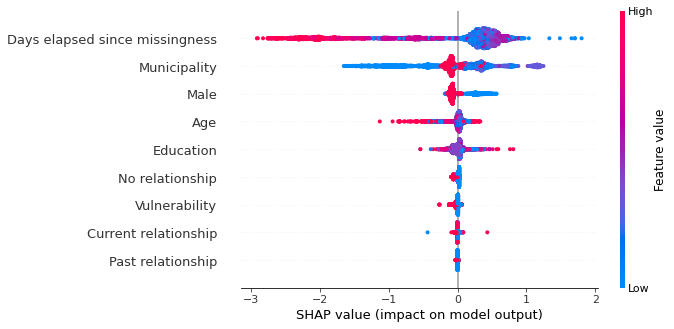

In [ ]:
# Check model features with respect to the outcome variable using
# the SHAP values plot
# interpret_model(lightgbm_model) # Visualize only
# Revision:
sns.reset_orig()
explainer = shap.Explainer(gradient_model) #, get_config('X_train')) # To save
shap_values = explainer(get_config('X_train'))
fig = shap.plots.beeswarm(shap_values, show = False)
f, ax = plt.gcf(), plt.gca()
## Comment labels below to double check that they correspond to the actual
## variable names (in Spanish)
ax.set_yticklabels(["Past relationship", "Current relationship",
                    "Vulnerability", "No relationship",
                    "Education", "Age", "Male",
                    "Municipality", "Days elapsed since missingness"])
f.savefig('shap_gbc_undersampl_2000_pycaret.png', dpi = 300,
          bbox_inches = 'tight')

In [ ]:
# Confirm label classes to double check the directionality of the effects
get_config('prep_pipe').named_steps["dtypes"].replacement
# 0 = Desaparecido, 1 = Apareció Vivo

{'0': 0, '1': 1}

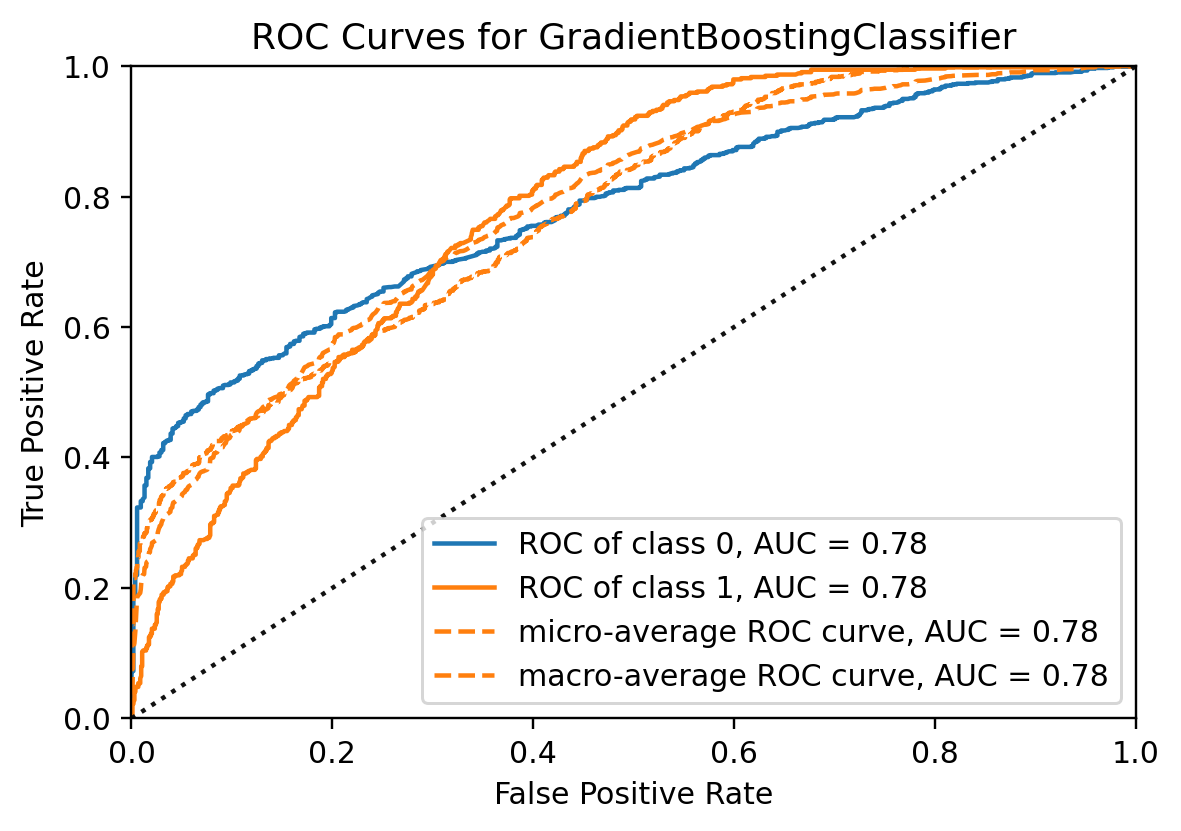

In [ ]:
# Check ROC curve (0 = Desaparecido; 1 = Apareció)
sns.reset_orig()
#plot_model(lightgbm_model, plot = 'auc')
# Revision:
plot_model(gradient_model, plot = 'auc', save = False, scale = 2)

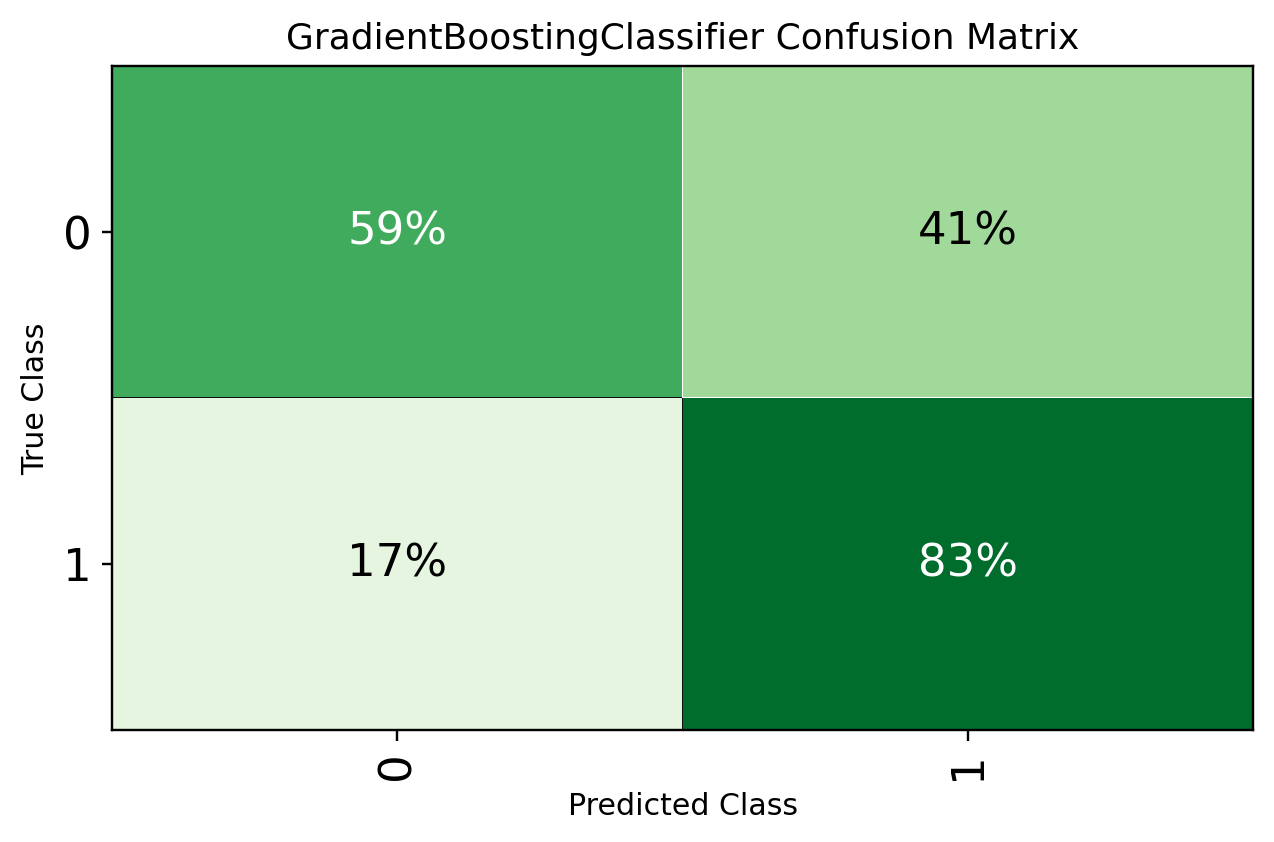

In [ ]:
# Plot confusion matrix
#plot_model(lightgbm_model, plot = 'confusion_matrix',
#           plot_kwargs = {'percent' : True}, save = False, scale = 3)
# Revision:
plot_model(gradient_model, plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True}, save = False, scale = 2)

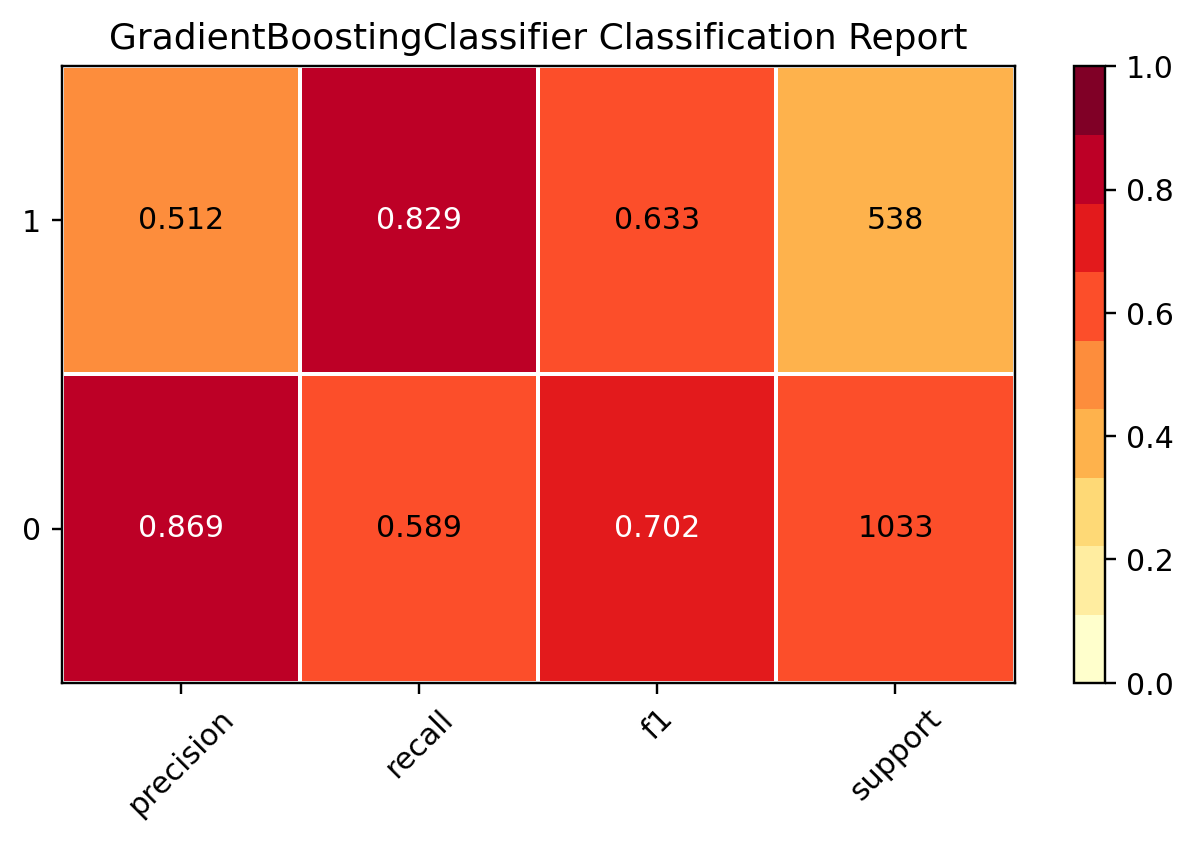

In [ ]:
# Plot classification report per label
#plot_model(lightgbm_model, plot = 'class_report', save = False, scale = 3)
# Revision:
plot_model(gradient_model, plot = 'class_report', save = False, scale = 2)

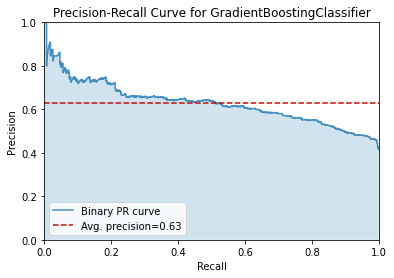

In [ ]:
# Revision:
# Precision Recall curve
plot_model(gradient_model, 'pr')

In [ ]:
# Finalize model
#finalize_model(lightgbm_model)
# Revision:
finalize_model(gradient_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2021, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Save model (and load it again)
# model = load_model('lightgbm_model') # To reload model
#save_model(lightgbm_model, 'lightgbm_model')
# Revision:
save_model(gradient_model, 'gbc_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['ID', 'status', 'año'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='aparecio',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
                                             max_leaf_nodes=None,
                                          

In [ ]:
# See individual predictions in the testing data
#predict_model(lightgbm_model, raw_score = True)
# Revision:
unseen = pd.read_csv("https://drive.google.com/uc?id=1-30ZnuObeyflNP85tu4u0eWiQqNEepwG")
unseen
predictions = predict_model(gradient_model, data = unseen, raw_score = True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5376,0.5368,0.5,0.3488,0.411,0.0499,0.0521


,ID,status,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,aparecio,Label,Score_0,Score_1
0,162461,Aparecio Vivo,69,Hombre,2.5,No,5348.0,152,NaN,1,0,0.5279,0.4721
1,162472,Desaparecido,73,Hombre,10.0,No,8076734.0,150,actual,0,1,0.3168,0.6832
2,162484,Aparecio Vivo,91,Hombre,5.0,No,8076734.0,150,actual,1,0,0.6602,0.3398
3,162498,Desaparecido,76,Hombre,7.5,No,8076734.0,149,ninguna,0,1,0.4111,0.5889
4,162502,Aparecio Vivo,61,Hombre,5.0,No,8076734.0,152,actual,1,1,0.4129,0.5871


### **b. Light Gradient Boosting Machine – Entire training sample**

In [ ]:
# Install lgbm package, as it's not (as of yet) included in Scikit Learn
!pip install lightgbm &> /dev/null
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
# Run and adjust the model
model = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                       colsample_bytree=1.0, importance_type='split',
                       learning_rate=0.1, max_depth=-1, min_child_samples=20,
                       min_child_weight=0.001, min_split_gain=0.0,
                       n_estimators=100, n_jobs=-1, num_leaves=31,
                       objective=None, random_state=2021, reg_alpha=0.0,
                       reg_lambda=0.0, silent='warn', subsample=1.0,
                       subsample_for_bin=200000, subsample_freq=0)
model.fit(X_train_proc, y_train_enc)

LGBMClassifier(random_state=2021)

In [ ]:
# Prediction
pred = model.predict(X_test_proc)
accuracy = model.score(X_test_proc, y_test_enc)
print(accuracy)

0.7008274984086569


In [ ]:
# Classification report in the training data (to assess variance)
pred_train = model.predict(X_train_proc)
target_names = ['Still missing', 'Found']
print("Performance with training data:" , "\n",
      classification_report(y_train_enc, pred_train,
                            target_names = target_names))

Performance with training data: 
                precision    recall  f1-score   support

Still missing       0.85      0.89      0.87      4133
        Found       0.77      0.69      0.73      2151

     accuracy                           0.82      6284
    macro avg       0.81      0.79      0.80      6284
 weighted avg       0.82      0.82      0.82      6284



In [ ]:
# Classification report in testing data
print("Performance with testing data:" , "\n",
      classification_report(y_test_enc, pred, target_names = target_names))

Performance with testing data: 
                precision    recall  f1-score   support

Still missing       0.76      0.80      0.78      1033
        Found       0.57      0.51      0.54       538

     accuracy                           0.70      1571
    macro avg       0.66      0.66      0.66      1571
 weighted avg       0.69      0.70      0.70      1571



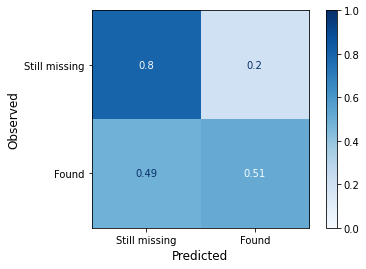

In [ ]:
# Confusion matrix: Testing data
sns.reset_orig()
cm = confusion_matrix(y_test_enc, pred, normalize = 'true',
                           labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                       display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(0, 1)
plt.xlabel("Predicted", size = 12)
plt.ylabel("Observed", size = 12)
plt.savefig('confusion_matrix_lgbm_all.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')
plt.title("Confusion matrix LGBM model - All")

Text(0, 0.5, 'True Positive Rate')

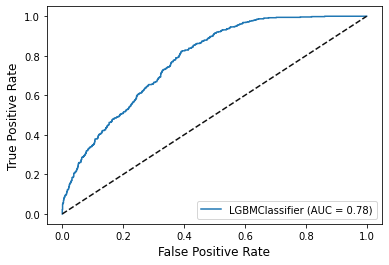

In [ ]:
# ROC curve: testing data
plot_roc_curve(model, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
#plt.title("ROC curve LGBM model - All")
plt.xlabel("False Positive Rate", size = 12)
plt.ylabel("True Positive Rate", size = 12)
plt.savefig('ROC_curve_lgbm_all.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

In [ ]:
# Model assessment in the testing data (Summary)
print("Metrics of evaluation of the LGBM model:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, pred),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, pred),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, pred),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, pred),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, pred), 2))

Metrics of evaluation of the LGBM model: 
accuracy  = 0.7 
precision = 0.57 
recall    = 0.51 
ROC AUC   = 0.66 
F1 score  = 0.54


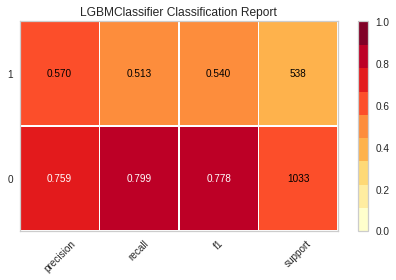

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(model, classes = model.classes_,
                                  support = True)
visualizer.fit(X_test_proc, y_test_enc)    # Fit the visualizer and the model
visualizer.score(X_test_proc, y_test_enc)  # Evaluate the model on the test data
fig = visualizer.show(outpath = "LGBMall_class_report.png")
f = plt.gcf() 
f.savefig('LGBMall_class_report.png', dpi = 300, bbox_inches = 'tight')

### **c. Light Gradient Boosting Machine – Undersampled training data**

In [ ]:
# Specify model and examine prediction
model_res = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                           colsample_bytree=1.0, importance_type='split',
                           learning_rate=0.1, max_depth=-1, min_child_samples=20,
                           min_child_weight=0.001, min_split_gain=0.0,
                           n_estimators=100, n_jobs=-1, num_leaves=31,
                           objective=None, random_state=2021, reg_alpha=0.0,
                           reg_lambda=0.0, silent='warn', subsample=1.0,
                           subsample_for_bin=200000,
                           subsample_freq=0).fit(X_res, y_res)
model_res.score(X_test_proc, y_test_enc)

0.6804583068109484

In [ ]:
# Model scores using undersampling in training data
pred_res = model_res.predict(X_test_proc)
print("Performance with testing data (undersampled training data):" , "\n",
      classification_report(y_test_enc, pred_res,
                            target_names = target_names))

Performance with testing data (undersampled training data): 
                precision    recall  f1-score   support

Still missing       0.85      0.63      0.72      1033
        Found       0.52      0.78      0.63       538

     accuracy                           0.68      1571
    macro avg       0.68      0.70      0.67      1571
 weighted avg       0.74      0.68      0.69      1571



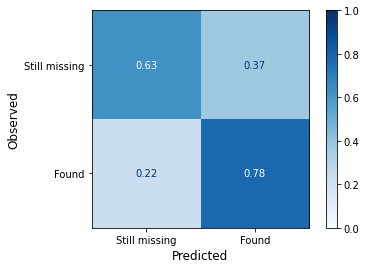

In [ ]:
# Confusion matrix: Testing data
sns.reset_orig()
cm = confusion_matrix(y_test_enc, pred_res, normalize = "true",
                           labels = model_res.classes_)
disp_res = ConfusionMatrixDisplay(confusion_matrix = cm,
                       display_labels = target_names)
disp_res.plot(cmap = plt.cm.Blues)
disp_res.ax_.get_images()[0].set_clim(0, 1)
plt.xlabel("Predicted", size = 12)
plt.ylabel("Observed", size = 12)
plt.savefig('confusion_matrix_lgbm_sub.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

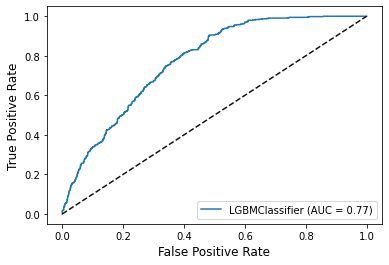

In [ ]:
# ROC curve: Testing data
plot_roc_curve(model_res, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
#plt.title("ROC curve of the LGBM model with undersampled training data")
plt.xlabel("False Positive Rate", size = 12)
plt.ylabel("True Positive Rate", size = 12)
plt.savefig('ROC_curve_lgbm_sub.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

In [ ]:
# Model assessment in testing data (Macro)
print("Metrics of evaluation of the LGBM model with undersampling:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, pred_res),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, pred_res),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, pred_res),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, pred_res),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, pred_res), 2))

Metrics of evaluation of the LGBM model with undersampling: 
accuracy  = 0.68 
precision = 0.52 
recall    = 0.78 
ROC AUC   = 0.7 
F1 score  = 0.63


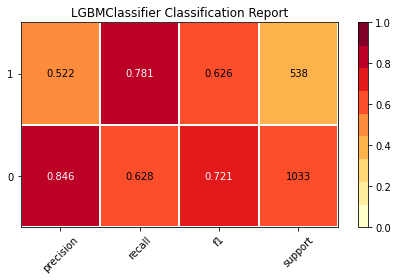

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(model_res, classes = model_res.classes_,
                                  support = True)
visualizer.fit(X_res, y_res)               # Fit the visualizer and the model
visualizer.score(X_test_proc, y_test_enc)  # Evaluate the model on the test data
fig = visualizer.show(outpath = "LGBMundersampling_class_report.png")
f, ax = plt.gcf(), plt.gca()
ax.set_yticklabels(["Still missing", "Found"])
f.savefig('LGBMundersampling_class_report.png', dpi = 300,
          bbox_inches = 'tight')

 97%|=================== | 4175/4302 [00:16<00:00]       

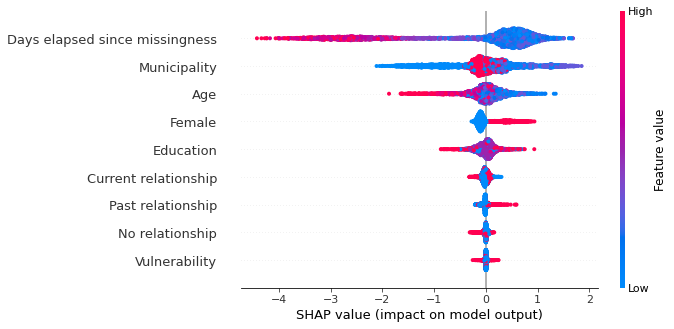

In [ ]:
# Plot and save features with the SHAP values
X_res2 = X_res.copy() # Workaround to adjust feature names in the figure
X_res2.columns = ["Female", "Current relationship", "No relationship",
                  "Past relationship", "Vulnerability",
                  "Age", "Education", "Municipality",
                  "Days elapsed since missingness"]
explainer = shap.Explainer(model_res, X_res2)
shap_values = explainer(X_res2)
fig = shap.plots.beeswarm(shap_values, show = False)
f = plt.gcf()
f.savefig('shap_lightgbm_undersampling.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Probabilities for each example of the testing data
probabilidades = model_res.predict_proba(X_test_proc)
prob_aparecer = pd.DataFrame(probabilidades, index = X_test_proc.index,
                             columns = ["prob_desaparec_pred",
                                        "prob_aparec_pred"])
prob_aparecer_x_y = pd.concat([X_test, prob_aparecer,
                               pd.DataFrame(y_test_enc, index = y_test.index,
                                            columns = ["aparecio"])],
                              axis = 1)
prob_aparecer_x_y

,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,prob_desaparec_pred,prob_aparec_pred,aparecio
149087,63,Mujer,4.966056,Sí,36708.0,7872,ninguna,0.944344,0.055656,0
10621,100,Hombre,4.966056,No,491387.0,6451,ninguna,0.977852,0.022148,0
84654,71,Hombre,5.000000,No,18678.0,7724,actual,0.937428,0.062572,0
123355,72,Hombre,4.966056,No,2394870.0,1576,ninguna,0.307530,0.692470,0
82512,60,Hombre,15.000000,No,2457680.0,6672,actual,0.861568,0.138432,0
...,...,...,...,...,...,...,...,...,...,...
84409,63,Mujer,4.966056,No,495200.0,2941,ninguna,0.418575,0.581425,1
101399,77,Hombre,10.000000,Sí,8076734.0,2339,actual,0.487001,0.512999,0
85655,86,Mujer,0.000000,No,8076734.0,2882,pasada,0.195247,0.804753,1
24131,62,Hombre,4.966056,No,562704.0,9467,actual,0.749354,0.250646,1


In [ ]:
# Save model (if you want to load it later)
#filename = 'finalized_lgbm_model.pkl'
# Revision:
filename = 'finalized_gbc_model.pkl'
with open(filename, 'wb') as file:  
    pickle.dump(model_res, file)

### **d. Light Gradient Boosting Machine - Oversampled training data**

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 2021)
X_train_res, y_train_res = sm.fit_sample(X_train_proc, y_train_enc.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 2151
Before OverSampling, counts of label '0': 4133 

After OverSampling, the shape of train_X: (8266, 9)
After OverSampling, the shape of train_y: (8266,) 

After OverSampling, counts of label '1': 4133
After OverSampling, counts of label '0': 4133


In [ ]:
# Run and adjust the model
model = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                       colsample_bytree=1.0,
                       importance_type='split', learning_rate=0.1, max_depth=-1,
                       min_child_samples=20, min_child_weight=0.001,
                       min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                       num_leaves=31, objective=None,
                       random_state=2021, reg_alpha=0.0, reg_lambda=0.0,
                       silent='warn', subsample=1.0, subsample_for_bin=200000,
                       subsample_freq=0)
model.fit(X_train_res, y_train_res)

LGBMClassifier(random_state=2021)

In [ ]:
# Prediction
pred = model.predict(X_test_proc)
accuracy = model.score(X_test_proc, y_test_enc)
print(accuracy)

0.6919159770846595


In [ ]:
# Classification report in testing data
print("Performance with testing data:" , "\n",
      classification_report(y_test_enc, pred, target_names = target_names))

Performance with testing data: 
                precision    recall  f1-score   support

Still missing       0.82      0.68      0.74      1033
        Found       0.54      0.72      0.62       538

     accuracy                           0.69      1571
    macro avg       0.68      0.70      0.68      1571
 weighted avg       0.72      0.69      0.70      1571



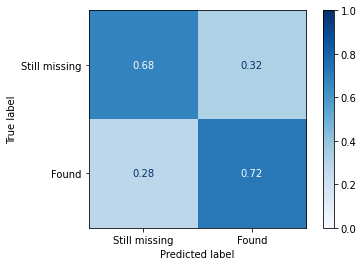

In [ ]:
# Confusion matrix: Testing data
sns.reset_orig()
cm = confusion_matrix(y_test_enc, pred, normalize = 'true',
                           labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                       display_labels = target_names)
disp.plot(cmap = plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(0, 1)
plt.title("Confusion matrix LGBM model - SMOTE")

Text(0.5, 1.0, 'ROC curve LGBM model oversampling training data')

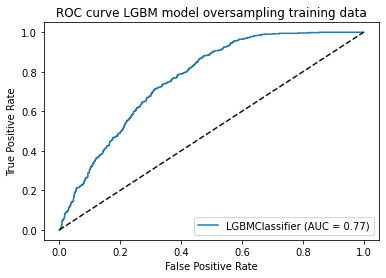

In [ ]:
# ROC curve: Testing data
plot_roc_curve(model, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve LGBM model oversampling training data")
plt.savefig('LGBM_oversampled_class_ROC curve.png', dpi = 300,
            bbox_inches = 'tight')

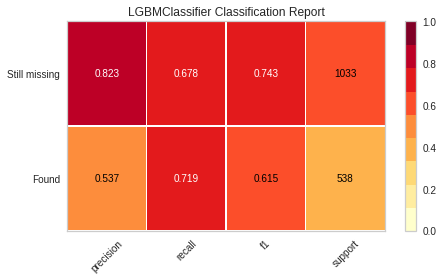

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(model, classes = model.classes_,
                                  support = True)
visualizer.fit(X_test_proc, y_test_enc)   # Fit the visualizer and the model
visualizer.score(X_test_proc, y_test_enc) # Evaluate the model on the test data
fig = visualizer.show(outpath = "LGBMoversampling_class_report.png")
f, ax = plt.gcf(), plt.gca()
ax.invert_yaxis()
ax.set_yticklabels(["Still missing", "Found"])
f.savefig('LGBMoversampling_class_report.png', dpi = 300,
          bbox_inches = 'tight')

In [ ]:
# Model assessment in testing data (Summary)
print("Metrics of assessment of the LGBM model:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, pred),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, pred),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, pred),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, pred),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, pred), 2))

Metrics of assessment of the LGBM model: 
accuracy  = 0.69 
precision = 0.54 
recall    = 0.72 
ROC AUC   = 0.7 
F1 score  = 0.62


### **e. Gradient Boosting Classifier – Entire training sample**

In [ ]:
# Specify model and look at prediction
clf = GradientBoostingClassifier(random_state = 2021).fit(X_train_proc,
                                                          y_train_enc)
clf.score(X_test_proc, y_test_enc)

0.705919796308084

In [ ]:
# Classification report in the training data (to assess variance)
target_names = ['Still missing', 'Found']
pred_train = clf.predict(X_train_proc)
print("Performance with training data:" , "\n",
      classification_report(y_train_enc, pred_train,
                            target_names = target_names))

Performance with training data: 
                precision    recall  f1-score   support

Still missing       0.79      0.84      0.81      4133
        Found       0.65      0.57      0.61      2151

     accuracy                           0.75      6284
    macro avg       0.72      0.70      0.71      6284
 weighted avg       0.74      0.75      0.74      6284



In [ ]:
# Classification report in the testing data
y_pred_test = clf.predict(X_test_proc)
print("Performance with the testing data:" , "\n",
      classification_report(y_test_enc, y_pred_test,
                            target_names = target_names))

Performance with the testing data: 
                precision    recall  f1-score   support

Still missing       0.76      0.80      0.78      1033
        Found       0.58      0.52      0.55       538

     accuracy                           0.71      1571
    macro avg       0.67      0.66      0.67      1571
 weighted avg       0.70      0.71      0.70      1571



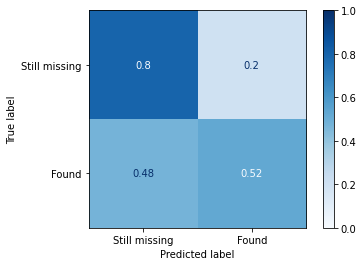

In [ ]:
# Confusion matrix: Testing data
sns.reset_orig()
cm_test = confusion_matrix(y_test_enc, y_pred_test, normalize = 'true',
                           labels = clf.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix = cm_test,
                       display_labels = target_names)
disp_test.plot(cmap = plt.cm.Blues)
disp_test.ax_.get_images()[0].set_clim(0, 1)
plt.title("Confusion matrix GBC model")

Text(0.5, 1.0, 'ROC curve GBC model entire training data')

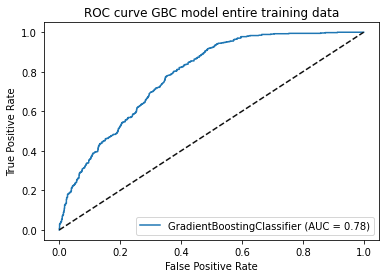

In [ ]:
# ROC curve: Testing data
plot_roc_curve(clf, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve GBC model entire training data")
plt.savefig('GBC_all_class_ROC curve.png', dpi = 300, bbox_inches = 'tight')

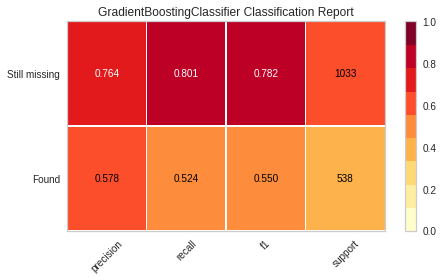

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf, classes = clf.classes_,
                                  support = True)
visualizer.fit(X_test_proc, y_test_enc)    # Fit the visualizer and the model
visualizer.score(X_test_proc, y_test_enc)  # Evaluate the model on the test data
fig = visualizer.show(outpath = "GBC_entire_class_report.png")
f, ax = plt.gcf(), plt.gca()
ax.invert_yaxis()
ax.set_yticklabels(["Still missing", "Found"])
f.savefig('GBC_entire_class_report.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Model assessment in the testing data (Summary)
print("Metrics of evaluation of the GBC model:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, y_pred_test),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, y_pred_test),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, y_pred_test),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, y_pred_test),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, y_pred_test), 2))

Metrics of evaluation of the GBC model: 
accuracy  = 0.71 
precision = 0.58 
recall    = 0.52 
ROC AUC   = 0.66 
F1 score  = 0.55


### **f. Gradient Boosting Classifier – Undersampled training data**

In [ ]:
# Specify model and look at prediction
clf_res = GradientBoostingClassifier(random_state = 2021).fit(X_res, y_res)
clf_res.score(X_test_proc, y_test_enc)

0.671546785486951

In [ ]:
# Model scores in the testing data (based on undersampled training data)
target_names = ['Still missing', 'Found']
y_pred_test = clf_res.predict(X_test_proc)
print("Performance with testing data:" , "\n",
      classification_report(y_test_enc, y_pred_test,
                            target_names = target_names))

Performance with testing data: 
                precision    recall  f1-score   support

Still missing       0.87      0.59      0.70      1033
        Found       0.51      0.83      0.63       538

     accuracy                           0.67      1571
    macro avg       0.69      0.71      0.67      1571
 weighted avg       0.75      0.67      0.68      1571



Text(0, 0.5, 'Observed')

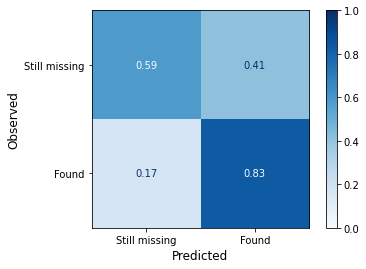

In [ ]:
# Confusion matrix: Testing data
cm_test = confusion_matrix(y_test_enc, y_pred_test, normalize = 'true',
                           labels = clf_res.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix = cm_test,
                       display_labels = target_names)
disp_test.plot(cmap = plt.cm.Blues)
disp_test.ax_.get_images()[0].set_clim(0, 1)
plt.xlabel("Predicted", size = 12)
plt.ylabel("Observed", size = 12)
plt.savefig('confusion_matrix_gbc_sub.png', dpi = 300, figsize = (8, 11),
            bbox_inches = 'tight')

Text(0.5, 1.0, 'ROC curve GBC model undersampling training data')

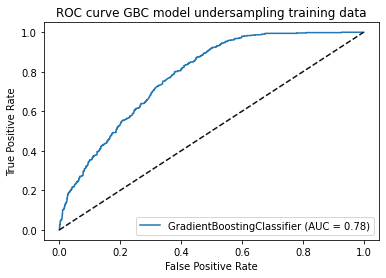

In [ ]:
# ROC curve: testing data
plot_roc_curve(clf_res, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve GBC model undersampling training data")
plt.savefig('GBC_undersampled_class_ROC curve.png', dpi = 300,
            bbox_inches = 'tight')

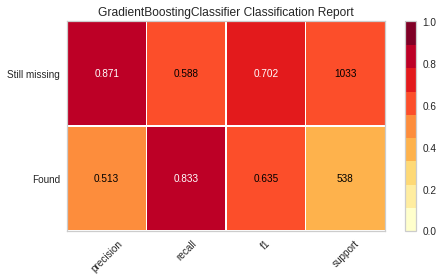

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf_res, classes = clf_res.classes_,
                                  support = True)
visualizer.fit(X_res, y_res)               # Fit the visualizer and the model
visualizer.score(X_test_proc, y_test_enc)  # Evaluate the model on the test data
fig = visualizer.show(outpath = "GBC_undersampled_class_report.png")
f, ax = plt.gcf(), plt.gca()
ax.invert_yaxis()
ax.set_yticklabels(["Still missing", "Found"])
f.savefig('GBC_undersampled_class_report.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Model assessment in the testing data (Summary)
print("Metrics of evaluation of the GBC model with undersampled training data:",
      "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, y_pred_test),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, y_pred_test),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, y_pred_test),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, y_pred_test),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, y_pred_test), 2))

Metrics of evaluation of the GBC model with undersampled training data: 
accuracy  = 0.67 
precision = 0.51 
recall    = 0.83 
ROC AUC   = 0.71 
F1 score  = 0.63


In [ ]:
# Revision:
# Probabilities for each example of the testing data
probabilidades = clf_res.predict_proba(X_test_proc)
prob_aparecer = pd.DataFrame(probabilidades, index = X_test_proc.index,
                             columns = ["prob_desaparec_pred",
                                        "prob_aparec_pred"])
prob_aparecer_x_y = pd.concat([X_test, prob_aparecer,
                               pd.DataFrame(y_test_enc, index = y_test.index,
                                            columns = ["aparecio"])],
                              axis = 1)
prob_aparecer_x_y

,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,prob_desaparec_pred,prob_aparec_pred,aparecio
149087,63,Mujer,4.966056,Sí,36708.0,7872,ninguna,0.913001,0.086999,0
10621,100,Hombre,4.966056,No,491387.0,6451,ninguna,0.942618,0.057382,0
84654,71,Hombre,5.000000,No,18678.0,7724,actual,0.951381,0.048619,0
123355,72,Hombre,4.966056,No,2394870.0,1576,ninguna,0.279067,0.720933,0
82512,60,Hombre,15.000000,No,2457680.0,6672,actual,0.863478,0.136522,0
...,...,...,...,...,...,...,...,...,...,...
84409,63,Mujer,4.966056,No,495200.0,2941,ninguna,0.187806,0.812194,1
101399,77,Hombre,10.000000,Sí,8076734.0,2339,actual,0.533802,0.466198,0
85655,86,Mujer,0.000000,No,8076734.0,2882,pasada,0.263287,0.736713,1
24131,62,Hombre,4.966056,No,562704.0,9467,actual,0.882319,0.117681,1


### **g. Random Forest Classifier – Entire training sample**

In [ ]:
# Third best model, also one that is less sensitive to class imbalance
rf_clf = RandomForestClassifier(random_state = 2021)
rf_clf.fit(X_train_proc, y_train_enc)
rf_clf.score(X_test_proc, y_test_enc)

0.6887332908975176

In [ ]:
# Classification report in the training data (to assess variance)
rf_y_pred_train = rf_clf.predict(X_train_proc)
print("Performance with training data:" , "\n",
      classification_report(y_train_enc, rf_y_pred_train,
                            target_names = target_names))

Performance with training data: 
                precision    recall  f1-score   support

Still missing       1.00      1.00      1.00      4133
        Found       1.00      1.00      1.00      2151

     accuracy                           1.00      6284
    macro avg       1.00      1.00      1.00      6284
 weighted avg       1.00      1.00      1.00      6284



In [ ]:
# Classification report in testing data
rf_y_pred_test = rf_clf.predict(X_test_proc)
print("Performance with testing data:" , "\n",
      classification_report(y_test_enc, rf_y_pred_test,
                            target_names = target_names))

Performance with testing data: 
                precision    recall  f1-score   support

Still missing       0.75      0.79      0.77      1033
        Found       0.55      0.50      0.53       538

     accuracy                           0.69      1571
    macro avg       0.65      0.64      0.65      1571
 weighted avg       0.68      0.69      0.69      1571



Text(0.5, 1.0, 'Confusion matrix Random Forest model')

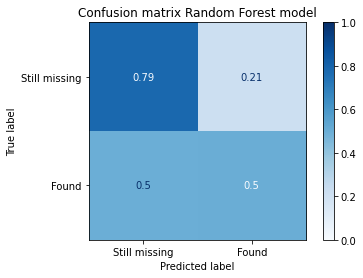

In [ ]:
# Confusion matrix and ROC curve: Testing data
rf_cm_test = confusion_matrix(y_test_enc, rf_y_pred_test, normalize = 'true',
                           labels = rf_clf.classes_)
rf_disp_test = ConfusionMatrixDisplay(confusion_matrix = rf_cm_test,
                       display_labels = target_names)
rf_disp_test.plot(cmap = plt.cm.Blues)
rf_disp_test.ax_.get_images()[0].set_clim(0, 1)
plt.title("Confusion matrix Random Forest model")

Text(0.5, 1.0, 'ROC curve Random Forest model')

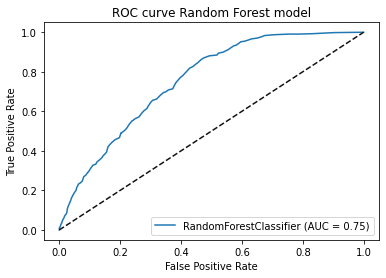

In [ ]:
# ROC curve: Testing data
plot_roc_curve(rf_clf, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve Random Forest model")

In [ ]:
# Model assessment in the testing data (Summary)
print("Metrics of evaluation of the Random Forest model:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, rf_y_pred_test),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, rf_y_pred_test),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, rf_y_pred_test),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, rf_y_pred_test),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, rf_y_pred_test), 2))

Metrics of evaluation of the Random Forest model: 
accuracy  = 0.69 
precision = 0.55 
recall    = 0.5 
ROC AUC   = 0.64 
F1 score  = 0.53


### **h. Random Forest Classifier – Undersampled training data**

In [ ]:
# Specify model and check prediction
rf_res = RandomForestClassifier(random_state = 2021).fit(X_res, y_res)
rf_res.score(X_test_proc, y_test_enc)

0.6766390833863781

In [ ]:
# Model scores of testing data based on resampled training data
y_pred_rf = rf_res.predict(X_test_proc)
print("Performance with testing data:" , "\n",
      classification_report(y_test_enc, y_pred_rf,
                            target_names = target_names))

Performance with testing data: 
                precision    recall  f1-score   support

Still missing       0.82      0.65      0.73      1033
        Found       0.52      0.72      0.60       538

     accuracy                           0.68      1571
    macro avg       0.67      0.69      0.67      1571
 weighted avg       0.72      0.68      0.68      1571



Text(0.5, 1.0, 'Confusion matrix Random Forest model – undersampled training data')

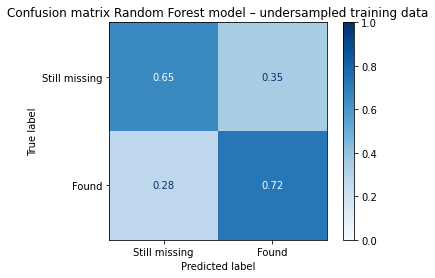

In [ ]:
# Confusion matrix: Testing data
cm_test = confusion_matrix(y_test_enc, y_pred_rf, normalize = 'true',
                           labels = rf_res.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix = cm_test,
                       display_labels = target_names)
disp_test.plot(cmap = plt.cm.Blues)
disp_test.ax_.get_images()[0].set_clim(0, 1)
plt.title("Confusion matrix Random Forest model – undersampled training data")

Text(0.5, 1.0, 'ROC curve Random Forest model – undersampled training data')

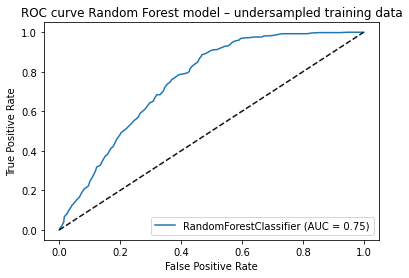

In [ ]:
# ROC curve: testing data
plot_roc_curve(rf_res, X_test_proc, y_test_enc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC curve Random Forest model – undersampled training data")

In [ ]:
# Model assessment in the testing data (Summary)
print("Metrics of evaluation of the random forest model:", "\n"
      "accuracy  =", np.around(accuracy_score(y_test_enc, y_pred_rf),
                               2), "\n"
      "precision =", np.around(precision_score(y_test_enc, y_pred_rf),
                               2), "\n"
      "recall    =", np. around(recall_score(y_test_enc, y_pred_rf),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_test_enc, y_pred_rf),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_test_enc, y_pred_rf), 2))

Metrics of evaluation of the random forest model: 
accuracy  = 0.68 
precision = 0.52 
recall    = 0.72 
ROC AUC   = 0.69 
F1 score  = 0.6


### **i. Unseen testing data**

In [ ]:
# Load (already cleaned) new, unseen data
# Notebook: "Desaparecidos_unseen.ipynb"
unseen = pd.read_csv("https://drive.google.com/uc?id=1-30ZnuObeyflNP85tu4u0eWiQqNEepwG")
unseen

,ID,status,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,aparecio
0,162461,Aparecio Vivo,69,Hombre,2.5,No,5348.0,152,NaN,1
1,162472,Desaparecido,73,Hombre,10.0,No,8076734.0,150,actual,0
2,162484,Aparecio Vivo,91,Hombre,5.0,No,8076734.0,150,actual,1
3,162498,Desaparecido,76,Hombre,7.5,No,8076734.0,149,ninguna,0
4,162502,Aparecio Vivo,61,Hombre,5.0,No,8076734.0,152,actual,1
5,162526,Desaparecido,76,Hombre,5.0,No,8076734.0,152,pasada,0
6,162535,Desaparecido,61,Hombre,10.0,No,8076734.0,148,ninguna,0
7,162540,Aparecio Vivo,73,Mujer,5.0,No,8076734.0,147,pasada,1
8,162553,Desaparecido,72,Hombre,0.0,No,8076734.0,147,actual,0
9,162583,Desaparecido,74,Hombre,NaN,No,122030.0,152,NaN,0


In [ ]:
# Split the data
Xnew = unseen.drop(["status", "ID", "aparecio"], axis = 1)
ynew = unseen["aparecio"].copy()

In [ ]:
# Impute missing values based on the training data
Xnew['escolaridad'] = Xnew['escolaridad'].replace(np.nan, X_train['escolaridad'].mean())
Xnew['municipio'] = Xnew['municipio'].fillna(X_train.loc[:, 'municipio'].mean())
Xnew['vulnerabilidad'] = Xnew['vulnerabilidad'].fillna(X_train.loc[:, 'vulnerabilidad'].mode()[0])
Xnew['relacion'] = Xnew['relacion'].fillna(X_train.loc[:, 'relacion'].mode()[0])
Xnew.isnull().sum()

edad              0
sexo              0
escolaridad       0
vulnerabilidad    0
municipio         0
dias              0
relacion          0
dtype: int64

In [ ]:
# Apply encoding
encoded_columns_unseen = enc.transform(Xnew[categorical_features]).toarray()
data_hot_encoded_unseen = pd.DataFrame(encoded_columns_unseen,
                                       index = unseen.index,
                                columns = enc.get_feature_names())
scaler_columns_unseen = scaler.transform(Xnew[numeric_features])
data_scaled_unseen = pd.DataFrame(scaler_columns_unseen, index = Xnew.index,
                           columns = numeric_features)
X_new_proc = pd.concat([data_hot_encoded_unseen, data_scaled_unseen], axis = 1)
y_new_enc = le.transform(ynew)

In [ ]:
# Performance with new data
pred_unseen = model_res.predict(X_new_proc)
print("Performance with new data (undersampled training data):" , "\n",
      classification_report(y_new_enc, pred_unseen,
                            target_names = target_names))

Performance with new data (undersampled training data): 
                precision    recall  f1-score   support

Still missing       0.76      0.44      0.56        63
        Found       0.38      0.70      0.49        30

     accuracy                           0.53        93
    macro avg       0.57      0.57      0.52        93
 weighted avg       0.63      0.53      0.54        93



In [ ]:
# Model assessment in unseen data (Summary)
print("Metrics of evaluation of the model in unseen data:", "\n"
      "accuracy  =", np.around(accuracy_score(y_new_enc, pred_unseen),
                               2), "\n"
      "precision =", np.around(precision_score(y_new_enc, pred_unseen),
                               2), "\n"
      "recall    =", np. around(recall_score(y_new_enc, pred_unseen),
                                2), "\n"
      "ROC AUC   =", np.around(roc_auc_score(y_new_enc, pred_unseen),
                               2), "\n"
      "F1 score  =", np.around(f1_score(y_new_enc, pred_unseen), 2))

Metrics of evaluation of the model in unseen data: 
accuracy  = 0.53 
precision = 0.38 
recall    = 0.7 
ROC AUC   = 0.57 
F1 score  = 0.49


Text(0.5, 1.0, 'Confusion matrix LGBM model – unseen data')

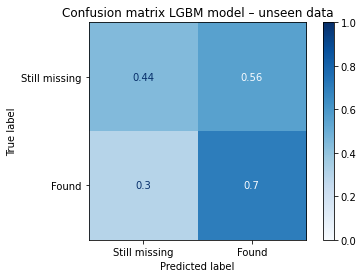

In [ ]:
# Confusion matrix: New data
sns.reset_orig()
cm_new = confusion_matrix(y_new_enc, pred_unseen, normalize = 'true',
                           labels = model_res.classes_)
disp_new = ConfusionMatrixDisplay(confusion_matrix = cm_new,
                       display_labels = target_names)
disp_new.plot(cmap = plt.cm.Blues)
disp_new.ax_.get_images()[0].set_clim(0, 1)
plt.title("Confusion matrix LGBM model – unseen data")
plt.savefig('confusion_matrix_unseen.png', dpi = 200, figsize = (8, 11),
            bbox_inches = 'tight')

In [ ]:
# Probabilities for each example of the unseen data
probabilidades_new = model_res.predict_proba(X_new_proc)
prob_aparecer_new = pd.DataFrame(probabilidades_new, index = X_new_proc.index,
                             columns = ["prob_desaparec_pred",
                                        "prob_aparec_pred"])
prob_aparecer_x_y_new = pd.concat([Xnew, prob_aparecer_new,
                               pd.DataFrame(y_new_enc, index = ynew.index,
                                            columns = ["aparecio"])],
                              axis = 1)
prob_aparecer_x_y_new

,edad,sexo,escolaridad,vulnerabilidad,municipio,dias,relacion,prob_desaparec_pred,prob_aparec_pred,aparecio
0,69,Hombre,2.500000,No,5.348000e+03,152,actual,0.395853,0.604147,1
1,73,Hombre,10.000000,No,8.076734e+06,150,actual,0.295671,0.704329,0
2,91,Hombre,5.000000,No,8.076734e+06,150,actual,0.594669,0.405331,1
3,76,Hombre,7.500000,No,8.076734e+06,149,ninguna,0.428235,0.571765,0
4,61,Hombre,5.000000,No,8.076734e+06,152,actual,0.389177,0.610823,1
5,76,Hombre,5.000000,No,8.076734e+06,152,pasada,0.524417,0.475583,0
6,61,Hombre,10.000000,No,8.076734e+06,148,ninguna,0.503226,0.496774,0
7,73,Mujer,5.000000,No,8.076734e+06,147,pasada,0.333359,0.666641,1
8,72,Hombre,0.000000,No,8.076734e+06,147,actual,0.389371,0.610629,0
9,74,Hombre,4.966056,No,1.220300e+05,152,actual,0.639750,0.360250,0
